In [14]:
import pandas as pd 
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import neptune.new as neptune
from sklearn import pipeline, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from math import sqrt
import sktime

# EDA - Human activity recognition

In [86]:
# Each of the data-files contains 54 columns per row, the columns contain the following data:
# – 1 timestamp (s)
# – 2 activityID (see II.2. for the mapping to the activities)
# – 3 heart rate (bpm)
# – 4-20 IMU chest
# – 21-37 IMU chest
# – 38-54 IMU ankle
# The IMU sensory data contains the following columns:
# – 1 temperature (°C)
# – 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit    **recommended to use  
# – 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
# – 8-10 3D-gyroscope data (rad/s)
# – 11-13 3D-magnetometer data (μT)
# – 14-17 orientation (invalid in this data collection)

# Activity IDs:
# – 1 lying
# – 2 sitting
# – 3 standing
# – 4 walking
# – 5 running
# – 6 cycling
# – 7 Nordic walking
# – 9 watching TV
# – 10 computer work
# – 11 car driving
# – 12 ascending stairs
# – 13 descending stairs
# – 16 vacuum cleaning
# – 17 ironing
# – 18 folding laundry
# – 19 house cleaning
# – 20 playing soccer
# – 24 rope jumping
# – 0 other (transient activities)

In [128]:
number_to_activity ={ 
        '0': 'other'
        ,'1': 'lying'
        ,'2': 'sitting'
        ,'3': 'standing'
        ,'4': 'walking'
        ,'5': 'running'
        ,'6': 'cycling'
        ,'7': 'Nordic walking'
        ,'9': 'watching TV'
        ,'10':'computer work'
        ,'11':'car driving'
        ,'12':'ascending stairs'
        ,'13':'descending stairs'
        ,'16':'vacuum cleaning'
        ,'17':'ironing'
        ,'18':'folding laundry'
        ,'19':'house cleaning'
        ,'20':'playing soccer'
        ,'21':'rope jumping'
        }
activity_to_number ={ 
         'other':'0' 
        ,'lying':'1' 
        ,'sitting':'2' 
        ,'standing':'3' 
        ,'walking':'4' 
        ,'running':'5' 
        ,'cycling':'6' 
        ,'Nordic walking':'7' 
        ,'watching TV':'9' 
        ,'computer work':'10'
        ,'car driving':'11' 
        ,'ascending stairs':'12' 
        ,'descending stairs':'13' 
        ,'vacuum cleaning':'16' 
        ,'ironing':'17' 
        ,'folding laundry':'18' 
        ,'house cleaning':'19' 
        ,'playing soccer':'20' 
        ,'rope jumping':'21' 
        }


In [3]:
df_102 = pd.read_csv('Protocol\subject102.dat')
df_102

5.64 0 NaN 33 2.79143 7.55389 -7.06374 2.87553 7.88823 -6.76139 1.0164 -0.28941 1.38207 -11.6508 -3.73683 31.1784 1 0 0 0 36.125 1.94739 9.59644 -3.12873 1.81868 9.49711 -2.91989 0.124025 0.112482 -0.0449469 -20.2905 -32.0492 8.67906 1 0 0 0 33.8125 9.84408 -0.808951 -1.64674 9.73055 -0.846832 -1.29665 -0.027148 -0.0311901 -0.0408973 -47.7695 -2.58701 59.8481 -0.0128709 0.747947 -0.0798406 0.658813
0       5.65 0 NaN 33 2.86086 7.43814 -7.21626 2.84248...                                                                                                                                                                                                                                                                                                                                                               
1       5.66 0 100 33 2.80997 7.0943 -7.52376 2.79373 ...                                                                                                                                                                                                                                                                                                                                                               
2       5.67 0 NaN 33 2.77138 6.98077 -7.52396 2.80627...                                                                                                                                                                                                                                                                                                                                                               
3       5.68 0 NaN 33 2.7671 7.13119 -7.67848 2.78766 ...                                                                                                                                                                                                                                                                                                                                                               
4       5.69 0 NaN 33 2.60926 7.13068 -7.87328 2.8163 ...                                                                                                                                                                                                                                                                                                                                                               
...                                                   ...                                                                                                                                                                                                                                                                                                                                                               
446994  4475.59 0 NaN 29.125 -0.0408284 -0.0507652 9.7...                                                                                                                                                                                                                                                                                                                                                               
446995  4475.6 0 NaN 29.125 -0.00410941 -0.0134532 9.7...                                                                                                                                                                                                                                                                                                                                                               
446996  4475.61 0 NaN 29.125 -0.0730027 -0.0111924 9.9...                                                                                                                                                                                                                                                                             

In [8]:
data = df_102.iloc[0][0].split(' ')

In [9]:
data

['5.65',
 '0',
 'NaN',
 '33',
 '2.86086',
 '7.43814',
 '-7.21626',
 '2.84248',
 '7.63164',
 '-6.8514',
 '1.08269',
 '-0.393965',
 '1.60935',
 '-11.6575',
 '-3.18648',
 '30.7215',
 '1',
 '0',
 '0',
 '0',
 '36.125',
 '1.7512',
 '9.6334',
 '-3.32601',
 '1.74445',
 '9.69355',
 '-2.96421',
 '0.132679',
 '0.0608292',
 '-0.0441676',
 '-20.6409',
 '-31.6989',
 '8.30648',
 '1',
 '0',
 '0',
 '0',
 '33.8125',
 '9.83968',
 '-0.807666',
 '-1.80115',
 '9.73049',
 '-0.816601',
 '-1.31189',
 '0.0128035',
 '-0.0363842',
 '-0.0148455',
 '-47.7624',
 '-2.81438',
 '60.3407',
 '0.0140248',
 '-0.74841',
 '0.0790426',
 '-0.65836']

In [10]:
print(f'timestamp(s): {data[0]}')
print(f'activity ID: {data[1]}')    
print(f'Heart rate: {data[2]}')
print(f'3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit" {data[37:][1:4]}')    
print(f'3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*: {data[37:][4:7]} ')
print(f'3D-gyroscope data (rad/s): {data[37:][7:10]}')
print(f'3D-magnetometer data (μT): {data[37:][10:13]}')
print(f'orientation (invalid in this data collection): {data[37:][13:17]}')


timestamp(s): 5.65
activity ID: 0
Heart rate: NaN
3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit" ['9.83968', '-0.807666', '-1.80115']
3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*: ['9.73049', '-0.816601', '-1.31189'] 
3D-gyroscope data (rad/s): ['0.0128035', '-0.0363842', '-0.0148455']
3D-magnetometer data (μT): ['-47.7624', '-2.81438', '60.3407']
orientation (invalid in this data collection): ['0.0140248', '-0.74841', '0.0790426', '-0.65836']


In [129]:
def read_data_and_preprocessing():
    data ={}
    columns_name = [
    'timestamp','activityID', 'heart-rate',
    # IMU hand
    'hand-temperature',
    'hand-acc-x','hand-acc-y', 'hand-acc-z', 
    'hand-x6','hand-y6', 'hand-z6',
    'hand-gyr-x','hand-gyr-y', 'hand-gyr-z',
    'hand-mag-x','hand-mag-y', 'hand-mag-z',
    # IMU chest 
    'chest-temperature',
    'chest-acc-x','chest-acc-y', 'chest-acc-z', 
    'chest-x6','chest-y6', 'chest-z6',
    'chest-gyr-x','chest-gyr-y', 'chest-gyr-z',
    'chest-mag-x','chest-mag-y', 'chest-mag-z',
    # IMU ankle
    'ankle-temperature',
    'ankle-acc-x','ankle-acc-y', 'ankle-acc-z', 
    'ankle-x6','ankle-y6', 'ankle-z6',
    'ankle-gyr-x','ankle-gyr-y', 'ankle-gyr-z',
    'ankle-mag-x','ankle-mag-y', 'ankle-mag-z']
    
    for subject_number in range(101,110):
        datContent = [i.split() for i in open(f'Protocol\subject{subject_number}.dat').readlines()] #Reading the date 
        # drop out orientation from all IMU sensors
        # data[3:17] #IMU chest data without orientation 
        # data[20:34] #IMU chest data without orientation 
        # data[37:51]  #IMU ankle data without orientation 
        datContent = [np.concatenate((row[:16],row[20:33],row[37:50])) for row in datContent]
        df = pd.DataFrame(datContent, columns=columns_name)
        # transform all columns from str to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df = df.drop(columns=['hand-x6','hand-y6', 'hand-z6','chest-x6','chest-y6', 'chest-z6','ankle-x6','ankle-y6', 'ankle-z6'])
        df['activityID'] = np.where(df['activityID']==24,21,df['activityID'])  # change rope jumping activityID from 24 to 22 
        
        data[subject_number] = df   # add subject's dataframe to dictionary  
        
    return data

In [59]:
subjects_data = read_data_and_preprocessing()

In [60]:
# saving the data for future work
with open('subjects_data_new.pickle', 'wb') as f:
    pickle.dump(subjects_data, f)

In [61]:
# loading pickled file
with open('subjects_data_new.pickle', 'rb') as handle:
    loaded_file = pickle.load(handle)

In [105]:
loaded_file.keys()

dict_keys([101, 102, 103, 104, 105, 106, 107, 108, 109])

In [120]:
df = loaded_file[109]
df.activityID.value_counts()

21    6391
0     2086
Name: activityID, dtype: int64

In [121]:
loaded_file

{101:         timestamp  activityID  heart-rate  hand-temperature  hand-acc-x  \
 0            8.38           0       104.0              30.0     2.37223   
 1            8.39           0         NaN              30.0     2.18837   
 2            8.40           0         NaN              30.0     2.37357   
 3            8.41           0         NaN              30.0     2.07473   
 4            8.42           0         NaN              30.0     2.22936   
 ...           ...         ...         ...               ...         ...   
 376412    3772.50           0         NaN              30.5     2.02477   
 376413    3772.51           0         NaN              30.5     2.10836   
 376414    3772.52           0         NaN              30.5     2.07163   
 376415    3772.53           0         NaN              30.5     2.19569   
 376416    3772.54           0         NaN              30.5     2.14774   
 
         hand-acc-y  hand-acc-z  hand-gyr-x  hand-gyr-y  hand-gyr-z  ...  \
 0   

In [68]:
def barh_plot_activity(df, subject_number):
    d = df.activityID.value_counts(normalize=True)
    y = d.values
    x = d.index
    activities = [number_to_activity[str(i)] for i in x]
    plt.figure(figsize = (8, 5))
    # creating the bar plot
    plt.barh(activities , y, color ='maroon')
    plt.ylabel("activity name")
    plt.xlabel("percentage of subject recorded time")
    plt.title(f"The ratio of each activity of a subject {subject_number}")
    # Add x, y gridlines
    plt.grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
    plt.show()

In [69]:
df_2 = subjects_data[102]

subject 101 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  376417.000000  376417.000000  34389.000000     374963.000000   
mean     1890.460000       5.422858    124.135479         32.429895   
std      1086.623725       6.346698     24.000340          1.236379   
min         8.380000       0.000000     78.000000         30.000000   
25%       949.420000       0.000000    104.000000         31.437500   
50%      1890.460000       3.000000    125.000000         32.812500   
75%      2831.500000       7.000000    136.000000         33.500000   
max      3772.540000      21.000000    183.000000         33.875000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  374963.000000  374963.000000  374963.000000  374963.000000   
mean       -3.349118       6.278528       3.407735       0.032741   
std         6.365465       5.196436       3.383241       1.072581   
min      -127.649000     -81.234400     -34.124800     -11.259100   
25%        -7.840210       3.591230       1.502020      -0.344787   
50%        -2.982460       6.009140       3.464280      -0.001522   
75%         1.669090       8.621120       5.551850       0.340209   
max        26.145800     106.898000     132.295000      16.483800   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  374963.000000  374963.000000  ...      375090.000000  375090.000000   
mean        0.046213       0.002308  ...          33.793903       9.413902   
std         0.870798       1.654828  ...           0.969374       5.868752   
min       -22.212700     -10.608800  ...          30.312500     -49.507200   
25%        -0.218379      -0.340880  ...          33.187500       8.893663   
50%         0.008506      -0.005281  ...          34.000000       9.624330   
75%         0.287393       0.339454  ...          34.687500      10.000600   
max         8.666640       9.998620  ...          35.000000     149.718000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  375090.000000  375090.000000  375090.000000  375090.000000   
mean        0.345152      -2.194919      -0.000110       0.000361   
std         7.443008       3.720882       0.996037       0.603546   
min      -155.356000    -133.640000     -11.688700      -7.807450   
25%        -2.067800      -3.354192      -0.190940      -0.047853   
50%        -0.177941      -1.733430      -0.001233       0.003658   
75%         1.997383      -0.523223       0.067853       0.168119   
max       155.960000      83.884500      13.142500       6.410380   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  375090.000000  375090.000000  375090.000000  375090.000000  
mean        0.013872     -50.873072      -4.103087      10.433775  
std         1.786058      25.724727      30.615311      29.524187  
min       -11.619400    -172.865000    -137.908000    -109.289000  
25%        -0.308403     -63.485375     -28.488200      -9.834780  
50%        -0.002747     -53.249850      -5.071440      11.097900  
75%         0.057149     -36.340800      20.731550      33.179775  
max         9.377020      97.525500     123.306000     124.806000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908641
hand-temperature     0.003863
hand-acc-x           0.003863
hand-acc-y           0.003863
hand-acc-z           0.003863
hand-gyr-x           0.003863
hand-gyr-y           0.003863
hand-gyr-z           0.003863
hand-mag-x           0.003863
hand-mag-y           0.003863
hand-mag-z           0.003863
chest-temperature    0.001352
chest-acc-x          0.001352
chest-acc-y          0.001352
chest-acc-z          0.001352
chest-gyr-x          0.001352
chest-gyr-y          0.001352
chest-gyr-z          0.001352
chest-mag-x          0.001352
chest-mag-y          0.001352
chest-mag-z          0.001352
ankle-temperature    0.003525
ankle-acc-x          0.003525
ankle-acc-y          0.003525
ankle-acc-z          0.003525
ankle-gyr-x          0.003525
ankle-gyr-y          0.003525
ankle-gyr-z          0.003525
ankle-mag-x          0.003525
ankle-mag-y          0.003525
ankle-mag-z          0.003525
dtype: flo

activity histogram:


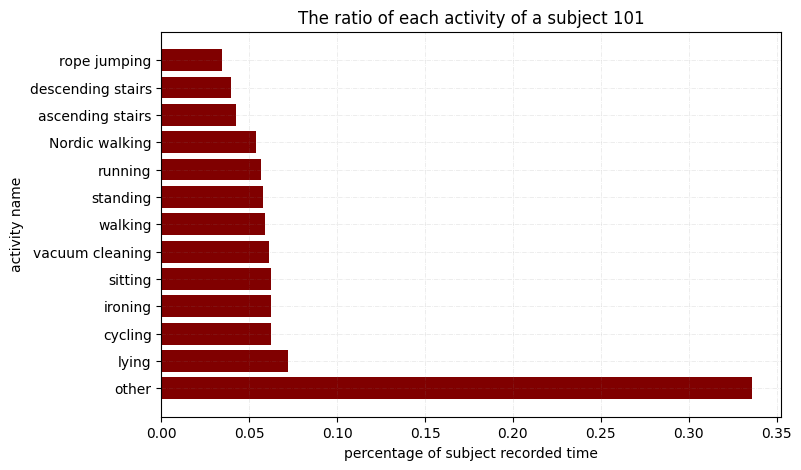

subject 102 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  447000.000000  447000.000000  40795.000000     444271.000000   
mean     2240.635000       4.890949    110.744528         32.251913   
std      1290.379295       6.224853     22.365414          2.102941   
min         5.640000       0.000000     74.000000         27.437500   
25%      1123.137500       0.000000     93.000000         30.437500   
50%      2240.635000       2.000000    109.000000         33.062500   
75%      3358.132500       7.000000    125.000000         34.125000   
max      4475.630000      21.000000    179.000000         34.625000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  444271.000000  444271.000000  444271.000000  444271.000000   
mean       -5.066690       4.720051       2.238075       0.025114   
std         5.958017       3.848774       4.217344       1.608742   
min       -70.948400     -50.029900     -38.217400     -21.982400   
25%        -9.128870       2.595720       0.283249      -0.348251   
50%        -6.700130       4.306010       1.946720      -0.001496   
75%        -1.077380       6.602405       5.348865       0.406936   
max        62.859600     105.780000     120.116000      22.766900   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  444271.000000  444271.000000  ...      444555.000000  444555.000000   
mean        0.042720      -0.007822  ...          34.132319       9.657814   
std         1.011712       1.630682  ...           1.507416       5.394504   
min       -18.196800     -16.699700  ...          29.500000     -52.498400   
25%        -0.222926      -0.413996  ...          34.125000       9.321595   
50%         0.006925      -0.007426  ...          34.687500       9.657880   
75%         0.241824       0.270562  ...          35.062500      10.051500   
max        16.983500      11.793700  ...          35.437500     152.558000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  444555.000000  444555.000000  444555.000000  444555.000000   
mean       -0.894160      -1.408111      -0.020898      -0.049982   
std         6.257366       3.306024       1.050285       0.610318   
min      -155.024000    -125.071000     -10.541900     -13.040100   
25%        -2.180820      -2.372515      -0.185668      -0.067760   
50%        -1.378410      -1.511930       0.000367      -0.005699   
75%        -0.027918      -0.620758       0.091894       0.100946   
max       155.996000      88.562700      16.442700      13.163500   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  444555.000000  444555.000000  444555.000000  444555.000000  
mean        0.002726     -30.201112       3.699441      18.656091  
std         1.787519      15.220718      17.648637      20.429621  
min       -11.746300    -103.775000     -65.339200     -70.650100  
25%        -0.377149     -40.381950      -8.710655       4.583705  
50%        -0.005756     -33.396400       3.949290      20.325500  
75%         0.052008     -18.838600      16.821900      35.452400  
max        11.715800      46.562000      71.031200     146.900000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908736
hand-temperature     0.006105
hand-acc-x           0.006105
hand-acc-y           0.006105
hand-acc-z           0.006105
hand-gyr-x           0.006105
hand-gyr-y           0.006105
hand-gyr-z           0.006105
hand-mag-x           0.006105
hand-mag-y           0.006105
hand-mag-z           0.006105
chest-temperature    0.000866
chest-acc-x          0.000866
chest-acc-y          0.000866
chest-acc-z          0.000866
chest-gyr-x          0.000866
chest-gyr-y          0.000866
chest-gyr-z          0.000866
chest-mag-x          0.000866
chest-mag-y          0.000866
chest-mag-z          0.000866
ankle-temperature    0.005470
ankle-acc-x          0.005470
ankle-acc-y          0.005470
ankle-acc-z          0.005470
ankle-gyr-x          0.005470
ankle-gyr-y          0.005470
ankle-gyr-z          0.005470
ankle-mag-x          0.005470
ankle-mag-y          0.005470
ankle-mag-z          0.005470
dtype: flo

activity histogram:


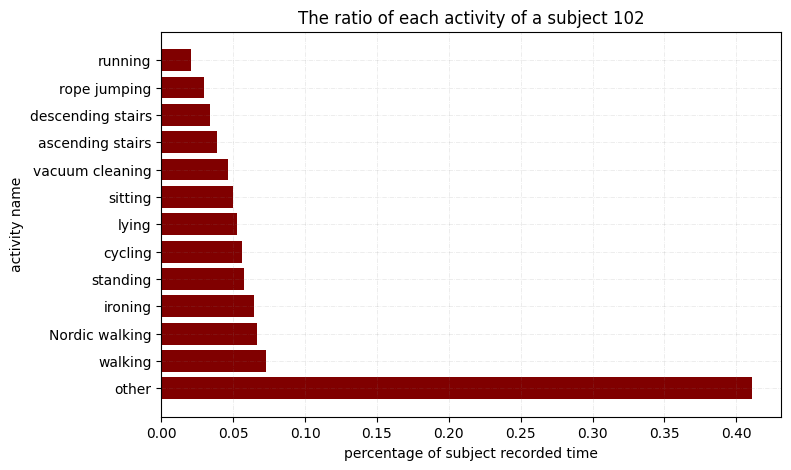

subject 103 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  252833.000000  252833.000000  23096.000000     252311.000000   
mean     1269.800000       5.463397     97.359803         31.697408   
std       729.867446       6.476542     21.541463          1.190222   
min         5.640000       0.000000     68.000000         28.062500   
25%       637.720000       0.000000     81.000000         31.250000   
50%      1269.800000       2.000000     90.000000         31.812500   
75%      1901.880000      13.000000    117.000000         32.625000   
max      2533.960000      17.000000    156.000000         33.250000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  252311.000000  252311.000000  252311.000000  252311.000000   
mean       -4.680230       4.705756       3.257324      -0.001839   
std         5.968184       3.632959       3.624717       1.363952   
min       -44.881000     -30.282000     -27.224800     -19.582800   
25%        -8.951240       2.570465       0.910057      -0.330881   
50%        -4.963620       4.498200       3.188780      -0.006142   
75%        -0.906465       7.566805       6.176330       0.355070   
max        21.033200      82.696500      44.052800      18.462500   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  252311.000000  252311.000000  ...      252306.000000  252306.000000   
mean       -0.023517      -0.040533  ...          33.454625       9.492918   
std         0.979723       1.446648  ...           1.178249       4.899606   
min        -5.820080     -12.706000  ...          29.500000     -37.221000   
25%        -0.212771      -0.192732  ...          32.812500       9.266565   
50%         0.010464      -0.003871  ...          33.875000       9.737760   
75%         0.223553       0.232190  ...          34.437500       9.913877   
max         8.657590       9.327110  ...          34.625000     155.166000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  252306.000000  252306.000000  252306.000000  252306.000000   
mean       -0.595684      -1.483454      -0.007258      -0.033156   
std         6.376451       3.743491       0.908358       0.522186   
min       -86.788300    -158.926000      -9.240700      -4.345720   
25%        -1.649635      -2.226350      -0.075364      -0.124152   
50%        -0.012980      -1.111670       0.007328      -0.009705   
75%         0.670692       0.081292       0.052586       0.032337   
max       156.190000      92.595800      11.223100       5.431100   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  252306.000000  252306.000000  252306.000000  252306.000000  
mean        0.026294     -25.531251       2.270606      18.105024  
std         1.577181      15.266545      15.938934      16.299567  
min        -6.541400    -105.243000     -82.569900     -51.671000  
25%        -0.154018     -36.710675      -5.657535       9.567550  
50%        -0.002323     -24.942350      -0.444829      20.087050  
75%         0.033589     -13.744500      16.246600      28.701000  
max         8.551940      58.894900      69.687000      91.796900  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908651
hand-temperature     0.002065
hand-acc-x           0.002065
hand-acc-y           0.002065
hand-acc-z           0.002065
hand-gyr-x           0.002065
hand-gyr-y           0.002065
hand-gyr-z           0.002065
hand-mag-x           0.002065
hand-mag-y           0.002065
hand-mag-z           0.002065
chest-temperature    0.000724
chest-acc-x          0.000724
chest-acc-y          0.000724
chest-acc-z          0.000724
chest-gyr-x          0.000724
chest-gyr-y          0.000724
chest-gyr-z          0.000724
chest-mag-x          0.000724
chest-mag-y          0.000724
chest-mag-z          0.000724
ankle-temperature    0.002084
ankle-acc-x          0.002084
ankle-acc-y          0.002084
ankle-acc-z          0.002084
ankle-gyr-x          0.002084
ankle-gyr-y          0.002084
ankle-gyr-z          0.002084
ankle-mag-x          0.002084
ankle-mag-y          0.002084
ankle-mag-z          0.002084
dtype: flo

activity histogram:


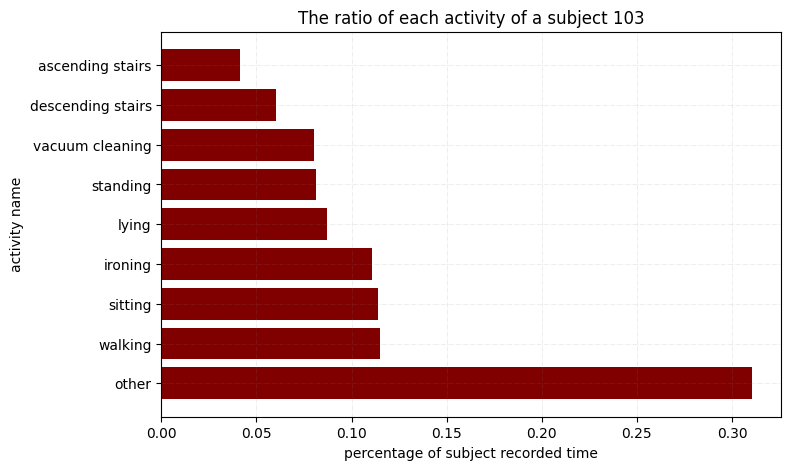

subject 104 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  329576.000000  329576.000000  30115.000000     327362.000000   
mean     1653.585000       5.268427    112.915989         31.800364   
std       951.405405       5.789789     19.564177          1.797355   
min         5.710000       0.000000     57.000000         27.437500   
25%       829.647500       0.000000    105.000000         30.375000   
50%      1653.585000       3.000000    113.000000         32.562500   
75%      2477.522500       7.000000    124.000000         33.062500   
max      3301.460000      17.000000    161.000000         33.750000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  327362.000000  327362.000000  327362.000000  327362.000000   
mean       -6.061583       3.683114       3.563609      -0.024392   
std         4.621688       3.321750       3.821756       1.203814   
min       -69.629800     -43.359300     -46.435600     -19.690500   
25%        -9.069057       1.632667       1.822407      -0.342244   
50%        -7.019200       3.473230       3.402360      -0.008386   
75%        -3.631182       5.851020       6.676325       0.203446   
max        16.296200      78.481300      56.856400      26.259100   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  327362.000000  327362.000000  ...      328475.000000  328475.000000   
mean        0.016033      -0.004695  ...          33.519357       9.586647   
std         0.709974       0.999285  ...           0.515424       4.083202   
min        -7.609010      -9.431420  ...          32.250000     -19.307100   
25%        -0.165669      -0.206869  ...          33.062500       9.184020   
50%         0.004040      -0.004022  ...          33.500000       9.556610   
75%         0.220174       0.240833  ...          33.875000       9.958900   
max        10.071800       9.010740  ...          34.437500      71.566100   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  328475.000000  328475.000000  328475.000000  328475.000000   
mean        0.946208      -1.834541       0.018978      -0.047424   
std         5.575805       2.400289       0.967636       0.332270   
min       -74.452700     -47.113600      -7.790290      -3.486750   
25%        -0.144020      -2.879635      -0.147975      -0.084380   
50%         0.848587      -1.929130      -0.000926      -0.007725   
75%         2.257200      -0.668381       0.056710       0.038983   
max        86.726100      53.549000       9.910960       3.921670   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  328475.000000  328475.000000  328475.000000  328475.000000  
mean        0.011870     -31.191721      -2.850653      16.543794  
std         1.576972      19.664968      19.721004      19.124311  
min        -6.346780     -99.271600     -75.187700     -59.771300  
25%        -0.281621     -43.019150     -15.430800       3.638400  
50%        -0.003052     -33.927900      -3.106010      19.799700  
75%         0.040815     -18.870950      13.188100      29.373600  
max         6.698660      57.492700      74.642000     104.093000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908625
hand-temperature     0.006718
hand-acc-x           0.006718
hand-acc-y           0.006718
hand-acc-z           0.006718
hand-gyr-x           0.006718
hand-gyr-y           0.006718
hand-gyr-z           0.006718
hand-mag-x           0.006718
hand-mag-y           0.006718
hand-mag-z           0.006718
chest-temperature    0.000646
chest-acc-x          0.000646
chest-acc-y          0.000646
chest-acc-z          0.000646
chest-gyr-x          0.000646
chest-gyr-y          0.000646
chest-gyr-z          0.000646
chest-mag-x          0.000646
chest-mag-y          0.000646
chest-mag-z          0.000646
ankle-temperature    0.003341
ankle-acc-x          0.003341
ankle-acc-y          0.003341
ankle-acc-z          0.003341
ankle-gyr-x          0.003341
ankle-gyr-y          0.003341
ankle-gyr-z          0.003341
ankle-mag-x          0.003341
ankle-mag-y          0.003341
ankle-mag-z          0.003341
dtype: flo

activity histogram:


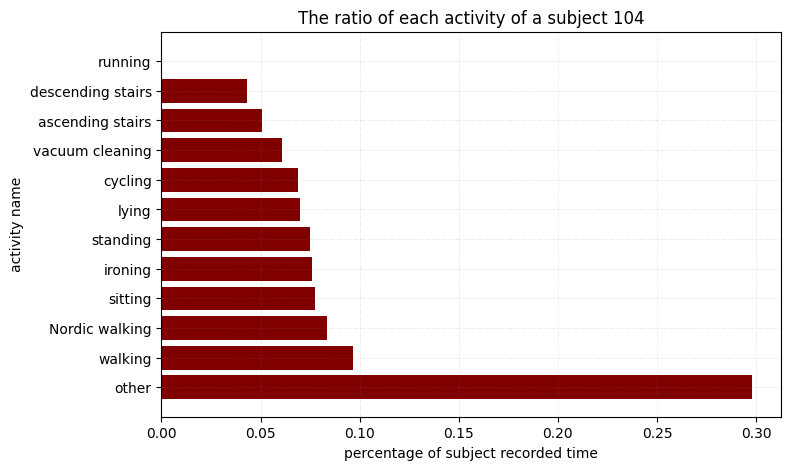

subject 105 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  374783.000000  374783.000000  34223.000000     373242.000000   
mean     1879.610000       5.812585    109.403354         34.727542   
std      1081.906773       6.196622     24.924682          0.489405   
min         5.700000       0.000000     70.000000         33.750000   
25%       942.655000       0.000000     90.000000         34.437500   
50%      1879.610000       4.000000    106.000000         34.812500   
75%      2816.565000       7.000000    123.000000         35.125000   
max      3753.520000      21.000000    182.000000         35.500000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  373242.000000  373242.000000  373242.000000  373242.000000   
mean       -4.335374       5.379049       3.375515      -0.005856   
std         5.756766       5.896408       3.786620       1.293162   
min       -90.760600     -65.538700     -38.907800     -27.804400   
25%        -8.642518       2.723425       1.329222      -0.448775   
50%        -4.443575       4.549640       3.187260      -0.010997   
75%         0.004188       7.577165       6.025665       0.335213   
max        42.891600     154.576000      76.639600      26.415800   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  373242.000000  373242.000000  ...      372803.000000  372803.000000   
mean        0.036000       0.022257  ...          34.164012       9.752750   
std         0.769686       1.384974  ...           0.243200       5.807568   
min        -7.428840     -14.264700  ...          33.500000     -66.308500   
25%        -0.212673      -0.403438  ...          34.062500       8.895640   
50%         0.009924      -0.002832  ...          34.187500       9.518390   
75%         0.270738       0.472700  ...          34.375000      10.358850   
max        13.251000      14.338400  ...          34.500000     154.168000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  372803.000000  372803.000000  372803.000000  372803.000000   
mean        0.137256      -3.199852       0.014629      -0.040120   
std         6.893323       3.343550       1.096377       0.623888   
min       -89.758600    -139.954000     -13.385600      -7.701040   
25%        -2.061835      -4.040965      -0.219134      -0.237959   
50%        -0.293927      -2.996120       0.004134      -0.013551   
75%         1.318995      -1.920150       0.155405       0.084077   
max       153.633000     156.730000      11.510900       6.002540   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  372803.000000  372803.000000  372803.000000  372803.000000  
mean        0.024625     -32.127083       2.280400      19.474495  
std         2.100005      14.785967      21.877278      15.931513  
min       -14.019600    -102.849000     -76.062800     -82.894900  
25%        -0.643571     -41.822000     -12.235250      10.191800  
50%        -0.009224     -35.183500       3.001460      20.883900  
75%         0.083281     -22.776850      20.501200      29.794200  
max        14.482700      70.941700      80.181400     104.832000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908686
hand-temperature     0.004112
hand-acc-x           0.004112
hand-acc-y           0.004112
hand-acc-z           0.004112
hand-gyr-x           0.004112
hand-gyr-y           0.004112
hand-gyr-z           0.004112
hand-mag-x           0.004112
hand-mag-y           0.004112
hand-mag-z           0.004112
chest-temperature    0.000832
chest-acc-x          0.000832
chest-acc-y          0.000832
chest-acc-z          0.000832
chest-gyr-x          0.000832
chest-gyr-y          0.000832
chest-gyr-z          0.000832
chest-mag-x          0.000832
chest-mag-y          0.000832
chest-mag-z          0.000832
ankle-temperature    0.005283
ankle-acc-x          0.005283
ankle-acc-y          0.005283
ankle-acc-z          0.005283
ankle-gyr-x          0.005283
ankle-gyr-y          0.005283
ankle-gyr-z          0.005283
ankle-mag-x          0.005283
ankle-mag-y          0.005283
ankle-mag-z          0.005283
dtype: flo

activity histogram:


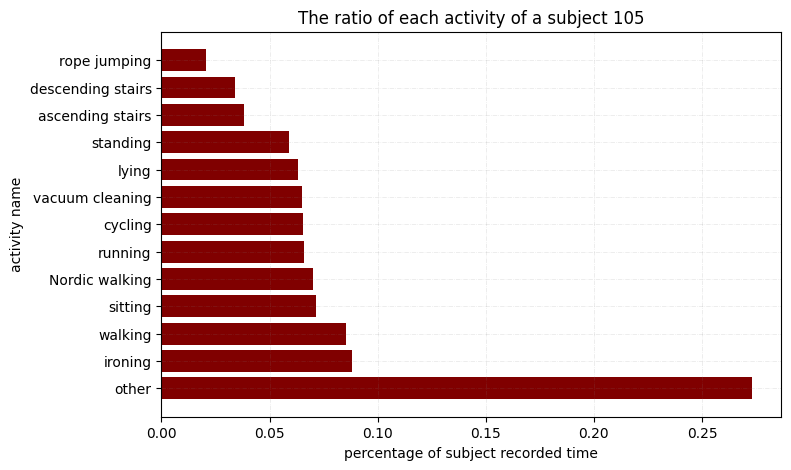

subject 106 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  361817.000000  361817.000000  33049.000000     360796.000000   
mean     1814.970000       5.415768    105.051257         32.241671   
std      1044.477155       5.990795     26.647474          2.039148   
min         5.890000       0.000000     60.000000         27.937500   
25%       910.430000       0.000000     86.000000         30.687500   
50%      1814.970000       3.000000     98.000000         33.375000   
75%      2719.510000       7.000000    116.000000         33.687500   
max      3624.050000      21.000000    176.000000         34.187500   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  360796.000000  360796.000000  360796.000000  360796.000000   
mean       -5.277900       4.699936       3.378156       0.007675   
std         7.095599       8.099851       4.337503       1.389233   
min      -145.367000     -55.446700    -101.452000     -14.731700   
25%        -8.990110       1.990215       0.987527      -0.399180   
50%        -6.330995       3.667555       3.465740      -0.008428   
75%        -0.746939       6.589070       6.327665       0.317411   
max        60.912600     155.699000     156.949000      23.865200   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  360796.000000  360796.000000  ...      360445.000000  360445.000000   
mean        0.041364      -0.002025  ...          34.717302       9.533558   
std         1.095666       1.608947  ...           0.418222       5.935697   
min        -7.401360     -12.827300  ...          33.812500    -146.851000   
25%        -0.226022      -0.299889  ...          34.500000       9.007770   
50%         0.004179      -0.005491  ...          34.812500       9.574520   
75%         0.248541       0.316134  ...          35.062500      10.032500   
max        14.133700      11.641100  ...          35.250000     154.643000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  360445.000000  360445.000000  360445.000000  360445.000000   
mean        0.284635      -2.610255       0.008180      -0.033220   
std         7.062712       3.711120       1.189130       0.459696   
min       -98.867100    -137.562000     -14.655000      -9.027570   
25%        -1.422150      -3.508340      -0.195256      -0.081863   
50%        -0.259112      -2.615000       0.004188      -0.004221   
75%         1.348290      -1.470280       0.093991       0.069412   
max       150.183000     113.568000      12.628500      11.754600   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  360445.000000  360445.000000  360445.000000  360445.000000  
mean        0.012977     -31.154582       0.245293      18.171673  
std         1.947164      13.860491      20.281803      18.867591  
min       -11.096200    -103.044000     -80.346600     -65.448000  
25%        -0.476032     -39.764200     -11.361400       4.544860  
50%        -0.004550     -32.586900      -0.950521      17.281400  
75%         0.059427     -21.338600      16.846900      34.026900  
max         9.714560      80.127100      90.038600     110.209000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908658
hand-temperature     0.002822
hand-acc-x           0.002822
hand-acc-y           0.002822
hand-acc-z           0.002822
hand-gyr-x           0.002822
hand-gyr-y           0.002822
hand-gyr-z           0.002822
hand-mag-x           0.002822
hand-mag-y           0.002822
hand-mag-z           0.002822
chest-temperature    0.000948
chest-acc-x          0.000948
chest-acc-y          0.000948
chest-acc-z          0.000948
chest-gyr-x          0.000948
chest-gyr-y          0.000948
chest-gyr-z          0.000948
chest-mag-x          0.000948
chest-mag-y          0.000948
chest-mag-z          0.000948
ankle-temperature    0.003792
ankle-acc-x          0.003792
ankle-acc-y          0.003792
ankle-acc-z          0.003792
ankle-gyr-x          0.003792
ankle-gyr-y          0.003792
ankle-gyr-z          0.003792
ankle-mag-x          0.003792
ankle-mag-y          0.003792
ankle-mag-z          0.003792
dtype: flo

activity histogram:


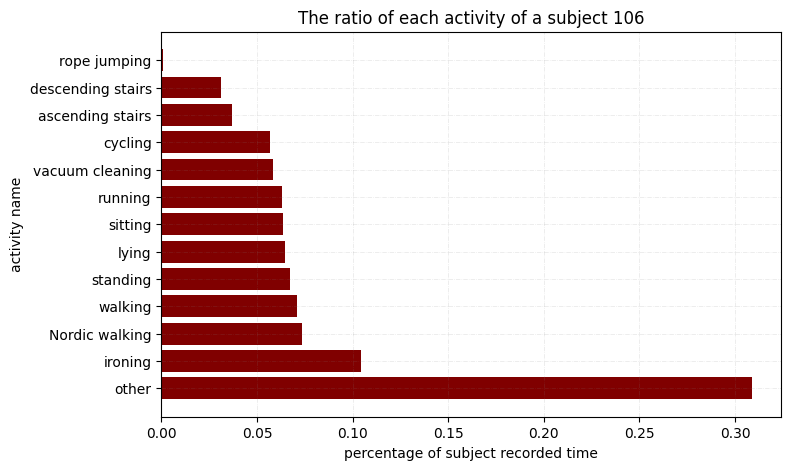

subject 107 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  313599.000000  313599.000000  28646.000000     312093.000000   
mean     1573.910000       5.825988     96.510542         32.942709   
std       905.283779       5.940061     22.203353          1.033476   
min         5.920000       0.000000     60.000000         29.187500   
25%       789.915000       0.000000     78.000000         32.812500   
50%      1573.910000       4.000000     95.000000         33.062500   
75%      2357.905000      12.000000    114.000000         33.687500   
max      3141.900000      17.000000    152.000000         34.250000   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  312093.000000  312093.000000  312093.000000  312093.000000   
mean       -5.722062       4.279513       3.434817      -0.008175   
std         4.658865       4.774483       3.617698       0.878371   
min       -68.695800     -63.792800     -26.229900     -13.780000   
25%        -9.235270       2.338690       0.972337      -0.242647   
50%        -6.748670       3.523210       2.426190      -0.002498   
75%        -1.898720       5.860920       6.897210       0.206944   
max        47.631400     155.257000      67.009500      16.395100   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  312093.000000  312093.000000  ...      312562.000000  312562.000000   
mean        0.011739       0.007411  ...          32.200806       9.311826   
std         0.517566       1.043086  ...           0.760914       6.076899   
min        -8.295970      -7.688460  ...          29.125000     -64.818100   
25%        -0.146236      -0.233531  ...          32.000000       9.013360   
50%         0.003057      -0.005872  ...          32.375000       9.374760   
75%         0.166915       0.214001  ...          32.687500       9.957387   
max         6.687870       7.013280  ...          33.187500     157.232000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  312562.000000  312562.000000  312562.000000  312562.000000   
mean       -0.229623      -3.588015       0.018150      -0.055600   
std         7.364409       3.445142       1.157082       0.678250   
min      -155.256000    -137.354000     -10.152500      -5.001890   
25%        -1.480780      -4.439070      -0.234765      -0.052061   
50%        -0.377553      -3.549255       0.004621      -0.001654   
75%         0.696329      -2.455742       0.091545       0.157764   
max       134.938000     151.510000      10.492300       3.527870   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  312562.000000  312562.000000  312562.000000  312562.000000  
mean       -0.003974     -27.790415      -0.301571      19.285376  
std         1.829038      17.619197      19.821234      19.106832  
min       -10.270900    -111.234000     -81.404600     -82.889600  
25%        -0.453179     -39.446200     -11.620500       5.711093  
50%        -0.005274     -29.522300      -1.764335      15.038600  
75%         0.045913     -12.826350      14.720025      34.453575  
max         8.775450      85.172400      96.682400      96.234400  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908654
hand-temperature     0.004802
hand-acc-x           0.004802
hand-acc-y           0.004802
hand-acc-z           0.004802
hand-gyr-x           0.004802
hand-gyr-y           0.004802
hand-gyr-z           0.004802
hand-mag-x           0.004802
hand-mag-y           0.004802
hand-mag-z           0.004802
chest-temperature    0.000820
chest-acc-x          0.000820
chest-acc-y          0.000820
chest-acc-z          0.000820
chest-gyr-x          0.000820
chest-gyr-y          0.000820
chest-gyr-z          0.000820
chest-mag-x          0.000820
chest-mag-y          0.000820
chest-mag-z          0.000820
ankle-temperature    0.003307
ankle-acc-x          0.003307
ankle-acc-y          0.003307
ankle-acc-z          0.003307
ankle-gyr-x          0.003307
ankle-gyr-y          0.003307
ankle-gyr-z          0.003307
ankle-mag-x          0.003307
ankle-mag-y          0.003307
ankle-mag-z          0.003307
dtype: flo

activity histogram:


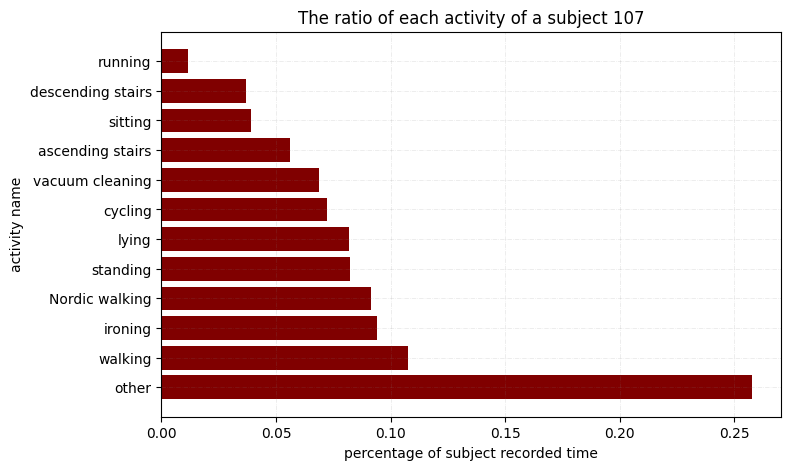

subject 108 dataframe details:


timestamp     activityID    heart-rate  hand-temperature  \
count  408031.000000  408031.000000  37179.000000     405880.000000   
mean     2046.040000       5.169921    115.253234         32.971459   
std      1177.885482       6.190611     30.757093          1.617991   
min         5.890000       0.000000     66.000000         30.562500   
25%      1025.965000       0.000000     91.000000         30.875000   
50%      2046.040000       3.000000    115.000000         33.687500   
75%      3066.115000       7.000000    128.000000         34.437500   
max      4086.190000      21.000000    202.000000         34.812500   

          hand-acc-x     hand-acc-y     hand-acc-z     hand-gyr-x  \
count  405880.000000  405880.000000  405880.000000  405880.000000   
mean       -5.384200      -4.169108       3.082906      -0.062992   
std         6.270890       5.924233       3.445358       1.307926   
min      -106.527000    -104.301000     -55.963700     -20.965600   
25%        -9.421582      -6.816100       0.867816      -0.314481   
50%        -6.244030      -2.863665       2.591190      -0.010368   
75%        -1.510340      -1.295555       6.141882       0.259672   
max        46.741800      62.033900     116.977000      19.601400   

          hand-gyr-y     hand-gyr-z  ...  ankle-temperature    ankle-acc-x  \
count  405880.000000  405880.000000  ...      406080.000000  406080.000000   
mean        0.059203      -0.033711  ...          33.206863       9.537535   
std         0.908610       1.524781  ...           1.148212       6.596850   
min       -13.390400     -15.218500  ...          31.062500    -155.068000   
25%        -0.167236      -0.268129  ...          31.812500       8.920235   
50%         0.003951      -0.006765  ...          33.500000       9.346635   
75%         0.206406       0.246119  ...          34.187500       9.901363   
max        10.432100      14.309000  ...          34.812500     157.040000   

         ankle-acc-y    ankle-acc-z    ankle-gyr-x    ankle-gyr-y  \
count  406080.000000  406080.000000  406080.000000  406080.000000   
mean       -0.824540      -3.281828       0.038543      -0.019731   
std         7.062641       3.628688       1.127744       0.764149   
min      -157.443000    -157.245000     -23.995000     -18.126900   
25%        -1.564182      -4.203730      -0.047154      -0.050963   
50%        -0.274175      -3.016290       0.014419       0.001051   
75%         1.332923      -2.161212       0.252508       0.119792   
max       157.293000     158.872000      17.420400      13.588200   

         ankle-gyr-z    ankle-mag-x    ankle-mag-y    ankle-mag-z  
count  406080.000000  406080.000000  406080.000000  406080.000000  
mean       -0.018394     -30.053008      10.135238      15.238070  
std         1.959380      14.247067      19.046270      17.114419  
min       -11.651900    -113.624000     -63.884200     -83.799400  
25%        -0.037195     -40.355300      -2.511130       2.183210  
50%         0.009395     -31.263400      12.539100      16.299600  
75%         0.292884     -18.804700      21.677550      25.720600  
max        16.528800      71.494600      82.544100     105.941000  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908882
hand-temperature     0.005272
hand-acc-x           0.005272
hand-acc-y           0.005272
hand-acc-z           0.005272
hand-gyr-x           0.005272
hand-gyr-y           0.005272
hand-gyr-z           0.005272
hand-mag-x           0.005272
hand-mag-y           0.005272
hand-mag-z           0.005272
chest-temperature    0.003206
chest-acc-x          0.003206
chest-acc-y          0.003206
chest-acc-z          0.003206
chest-gyr-x          0.003206
chest-gyr-y          0.003206
chest-gyr-z          0.003206
chest-mag-x          0.003206
chest-mag-y          0.003206
chest-mag-z          0.003206
ankle-temperature    0.004781
ankle-acc-x          0.004781
ankle-acc-y          0.004781
ankle-acc-z          0.004781
ankle-gyr-x          0.004781
ankle-gyr-y          0.004781
ankle-gyr-z          0.004781
ankle-mag-x          0.004781
ankle-mag-y          0.004781
ankle-mag-z          0.004781
dtype: flo

activity histogram:


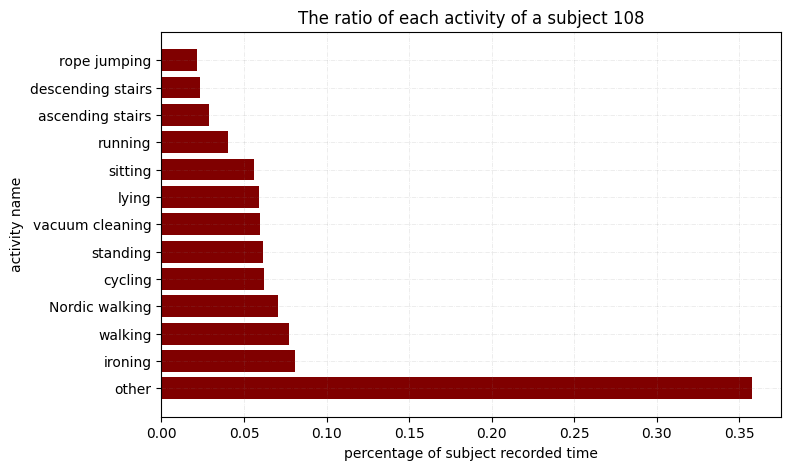

subject 109 dataframe details:


timestamp   activityID  heart-rate  hand-temperature   hand-acc-x  \
count  8477.000000  8477.000000  776.000000       8474.000000  8474.000000   
mean     57.850000    15.832370  147.740979         25.017554    -2.278159   
std      24.472434     9.045744    7.799664          0.115618     6.146012   
min      15.470000     0.000000  138.000000         24.750000   -69.717600   
25%      36.660000    21.000000  141.000000         24.937500    -6.279738   
50%      57.850000    21.000000  146.000000         25.062500    -2.116955   
75%      79.040000    21.000000  153.000000         25.125000     1.297127   
max     100.230000    21.000000  162.000000         25.187500    16.909200   

        hand-acc-y   hand-acc-z   hand-gyr-x   hand-gyr-y   hand-gyr-z  ...  \
count  8474.000000  8474.000000  8474.000000  8474.000000  8474.000000  ...   
mean      7.992721    -0.326956     0.230890     0.024984     0.062659  ...   
std      11.159546     5.926775     1.866167     1.854194     2.001904  ...   
min     -81.681200   -38.042400   -28.135400   -17.849500    -9.773900  ...   
25%       0.477708    -3.721697    -0.848451    -1.015518    -1.217725  ...   
50%       6.168840     0.492557     0.205404     0.105704     0.138294  ...   
75%      13.576950     3.243082     1.395890     1.287325     1.427043  ...   
max      65.430400   157.760000    21.640500    23.077900     6.954030  ...   

       ankle-temperature  ankle-acc-x  ankle-acc-y  ankle-acc-z  ankle-gyr-x  \
count        8468.000000  8468.000000  8468.000000  8468.000000  8468.000000   
mean           31.395231     9.822443     0.918866    -3.275774    -0.011161   
std             0.086898    12.865949    11.825007     9.407364     1.725868   
min            31.187500  -127.849000  -157.615000  -109.686000   -11.940400   
25%            31.312500     3.102960    -2.434350    -4.840433    -0.746524   
50%            31.437500     9.345955    -0.212124    -2.416595     0.000788   
75%            31.437500    13.364725     4.479093     0.689291     0.693021   
max            31.500000   156.671000   156.114000   160.516000     9.563010   

       ankle-gyr-y  ankle-gyr-z  ankle-mag-x  ankle-mag-y  ankle-mag-z  
count  8468.000000  8468.000000  8468.000000  8468.000000  8468.000000  
mean     -0.041513     0.009701   -37.270947   -17.006554     9.993259  
std       0.967485     2.034075     7.203337    16.257600     7.096208  
min      -8.849780    -7.271180   -47.390700   -42.370100   -22.381700  
25%      -0.537460    -0.910230   -43.341225   -28.139325     6.771300  
50%      -0.013778     0.007605   -38.001200   -22.101350    10.499150  
75%       0.469633     0.991644   -33.258125    -9.205520    13.775950  
max       4.356320    12.870400    -2.950730    45.144000    31.049500  

[8 rows x 33 columns]

percentage of na values:


timestamp            0.000000
activityID           0.000000
heart-rate           0.908458
hand-temperature     0.000354
hand-acc-x           0.000354
hand-acc-y           0.000354
hand-acc-z           0.000354
hand-gyr-x           0.000354
hand-gyr-y           0.000354
hand-gyr-z           0.000354
hand-mag-x           0.000354
hand-mag-y           0.000354
hand-mag-z           0.000354
chest-temperature    0.006016
chest-acc-x          0.006016
chest-acc-y          0.006016
chest-acc-z          0.006016
chest-gyr-x          0.006016
chest-gyr-y          0.006016
chest-gyr-z          0.006016
chest-mag-x          0.006016
chest-mag-y          0.006016
chest-mag-z          0.006016
ankle-temperature    0.001062
ankle-acc-x          0.001062
ankle-acc-y          0.001062
ankle-acc-z          0.001062
ankle-gyr-x          0.001062
ankle-gyr-y          0.001062
ankle-gyr-z          0.001062
ankle-mag-x          0.001062
ankle-mag-y          0.001062
ankle-mag-z          0.001062
dtype: flo

activity histogram:


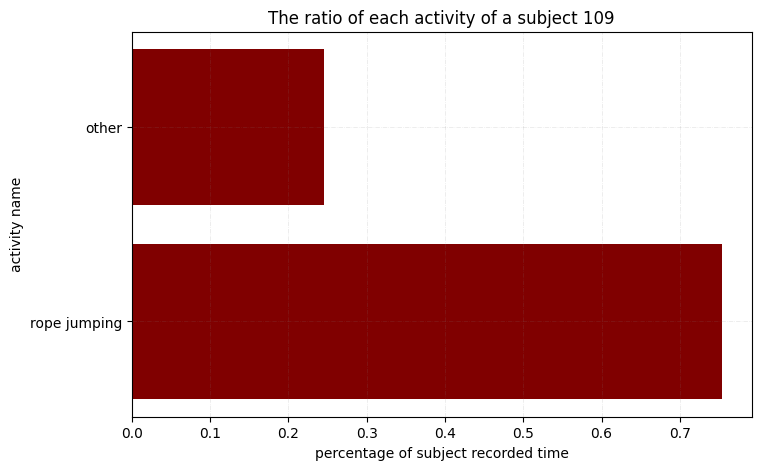

In [70]:
for subject in subjects_data.keys():
    print(f'subject {subject} dataframe details:')
    df = subjects_data[subject]
    display(df.describe())
    print('percentage of na values:')
    display(df.isna().mean())
    print('activity histogram:')
    barh_plot_activity(df,subject)

In [224]:
def plot_ts(df):
    fig, ax = plt.subplots(len(df.columns[2:]), 1, figsize=(14,50), sharex=True)
    i = 0
    for col in df.columns[2:]:
        ax[i].plot(df['timestamp'], df[col], color='r', alpha=0.5)
        ax[i].set_title(col)
        ax[i].grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
        i+=1
    plt.show()

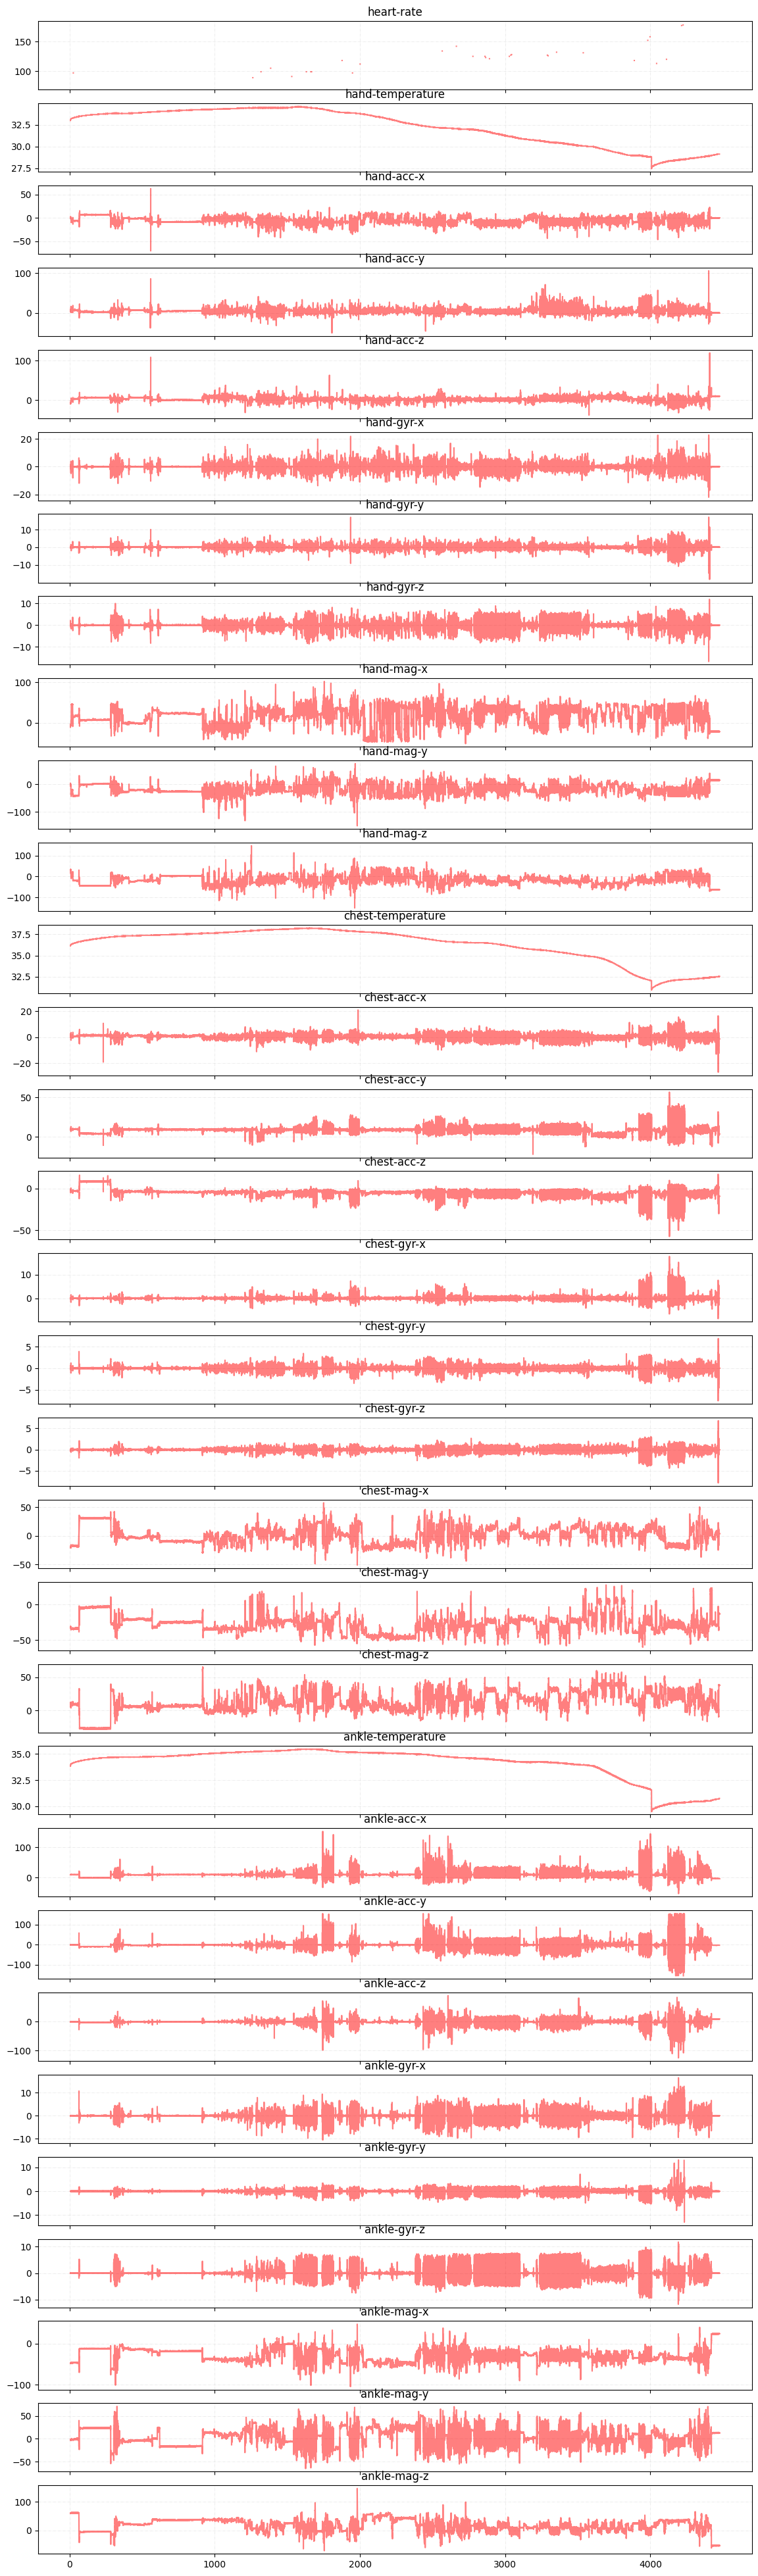

In [227]:
plot_ts(subjects_data[102])

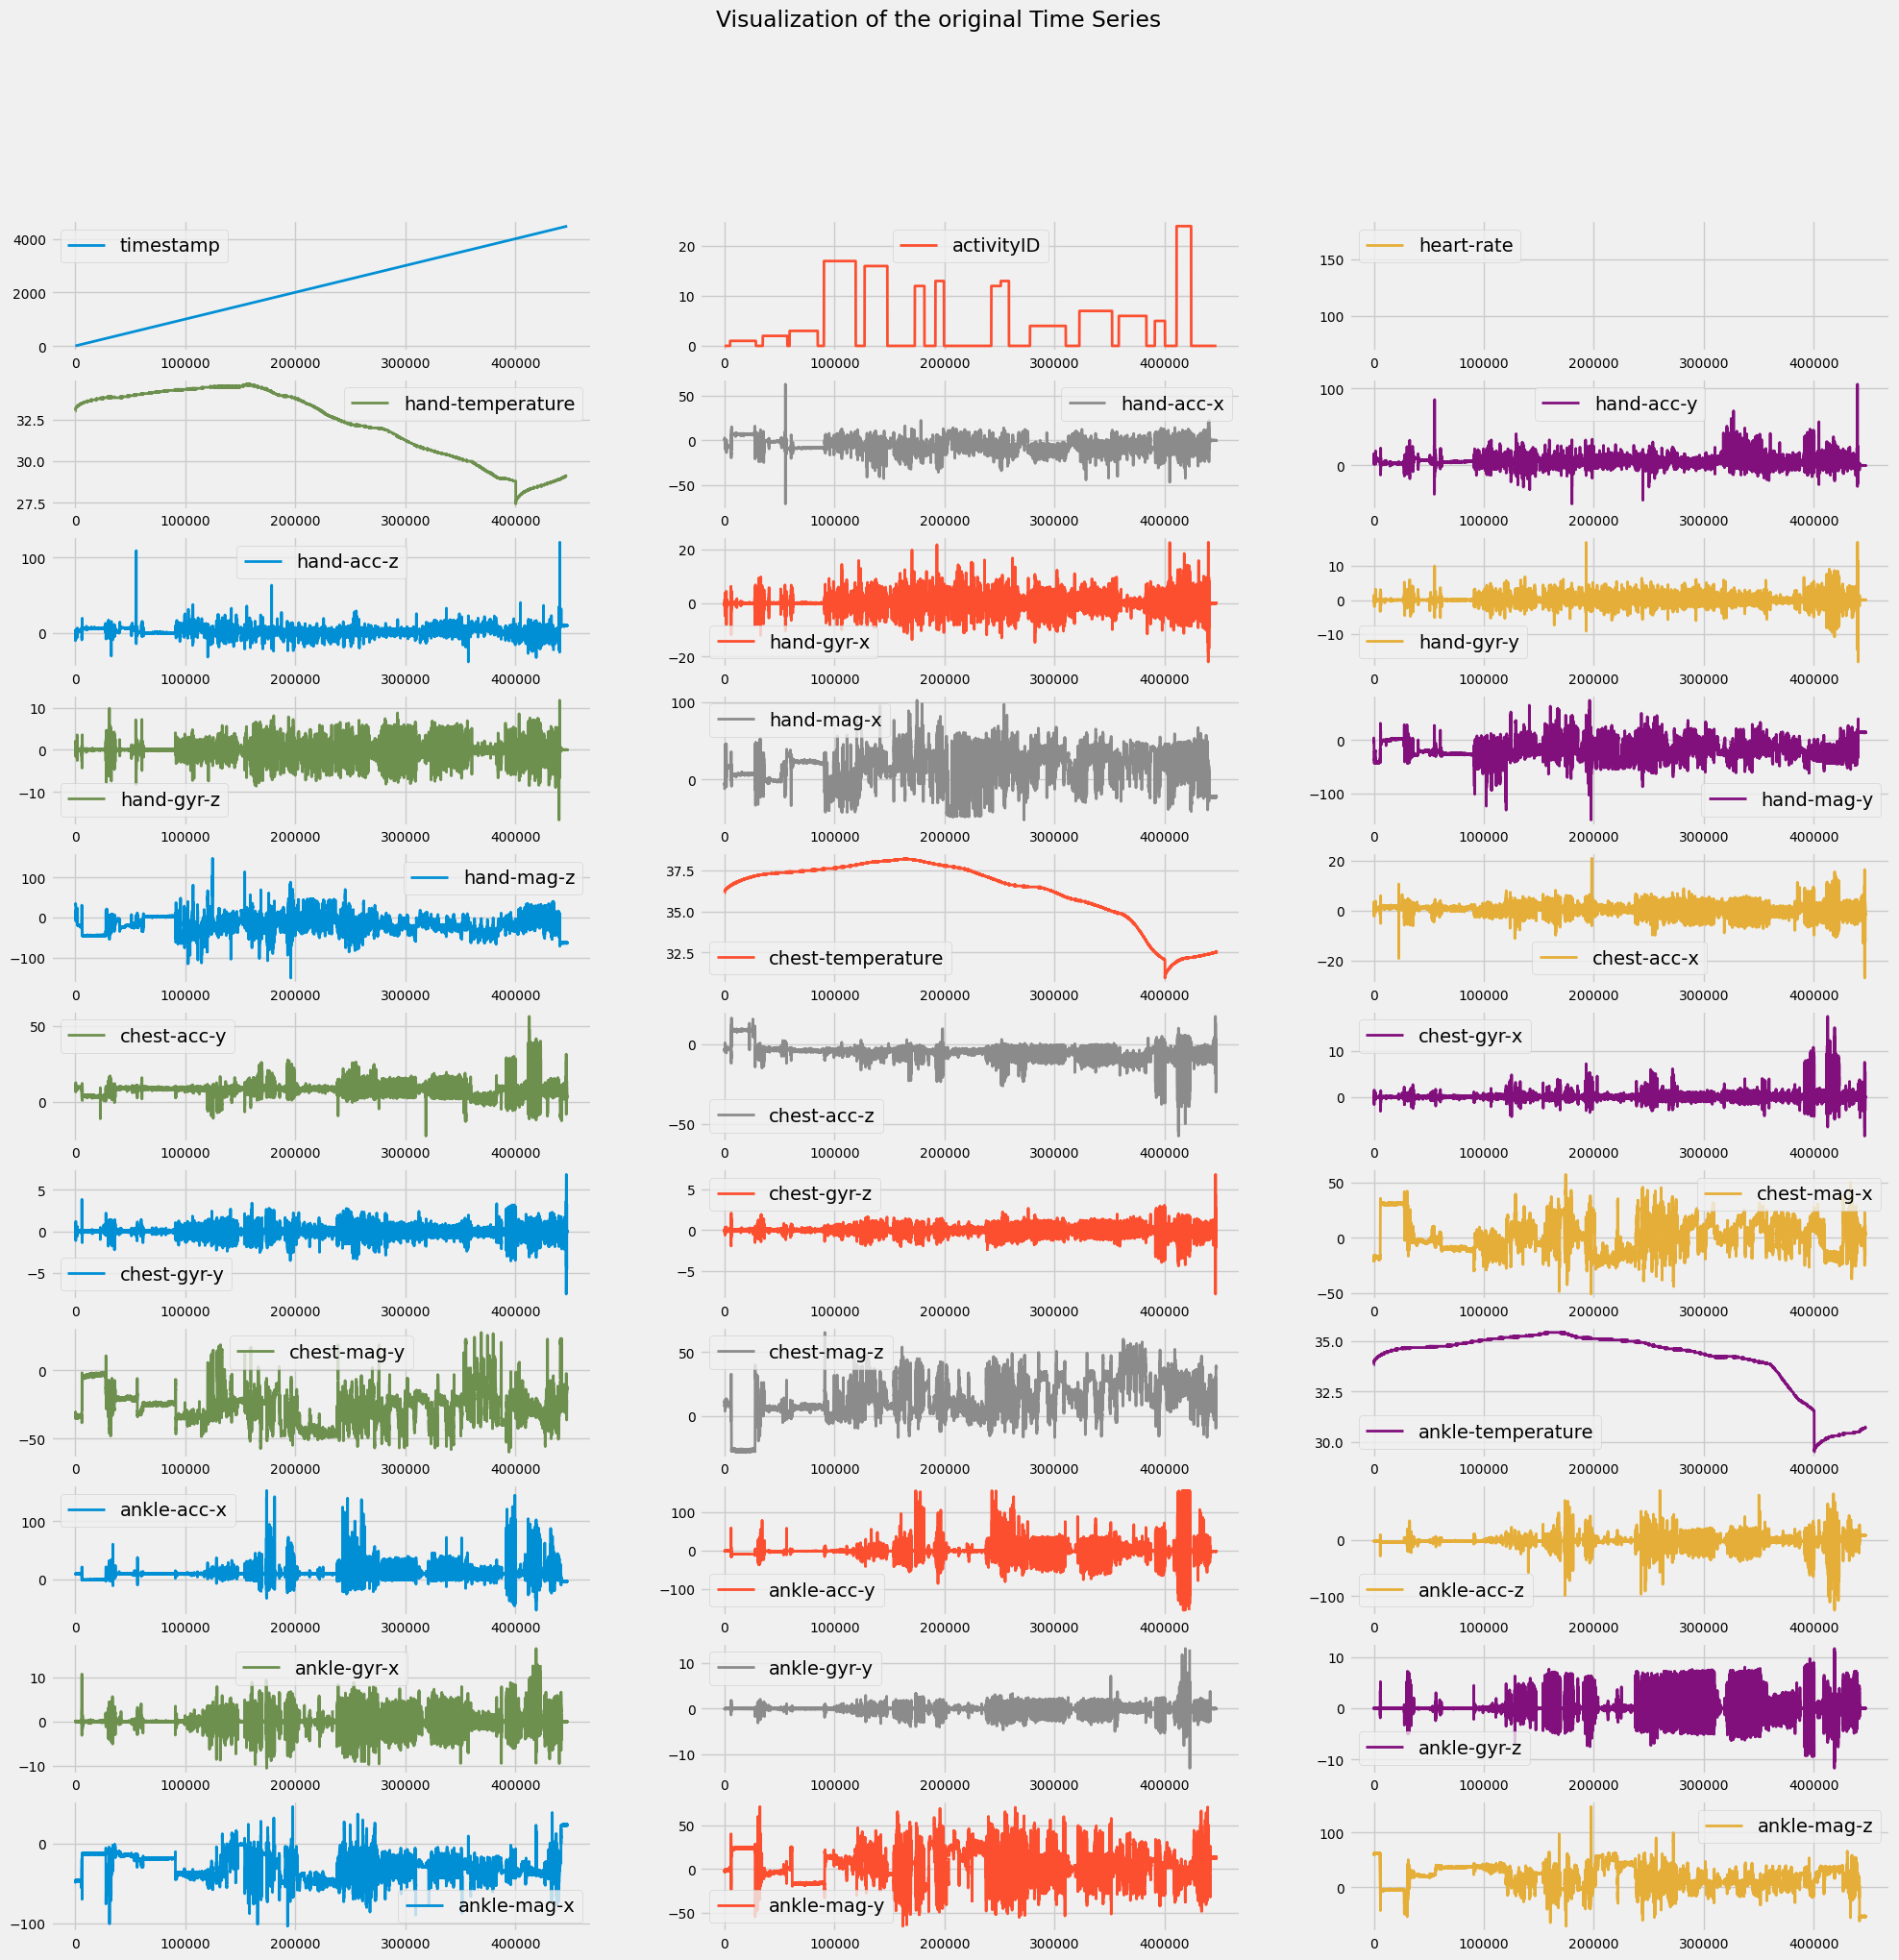

In [9]:
# Plot the time series
plt.style.use('fivethirtyeight')
df_2.plot(subplots=True,
        layout=(11, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

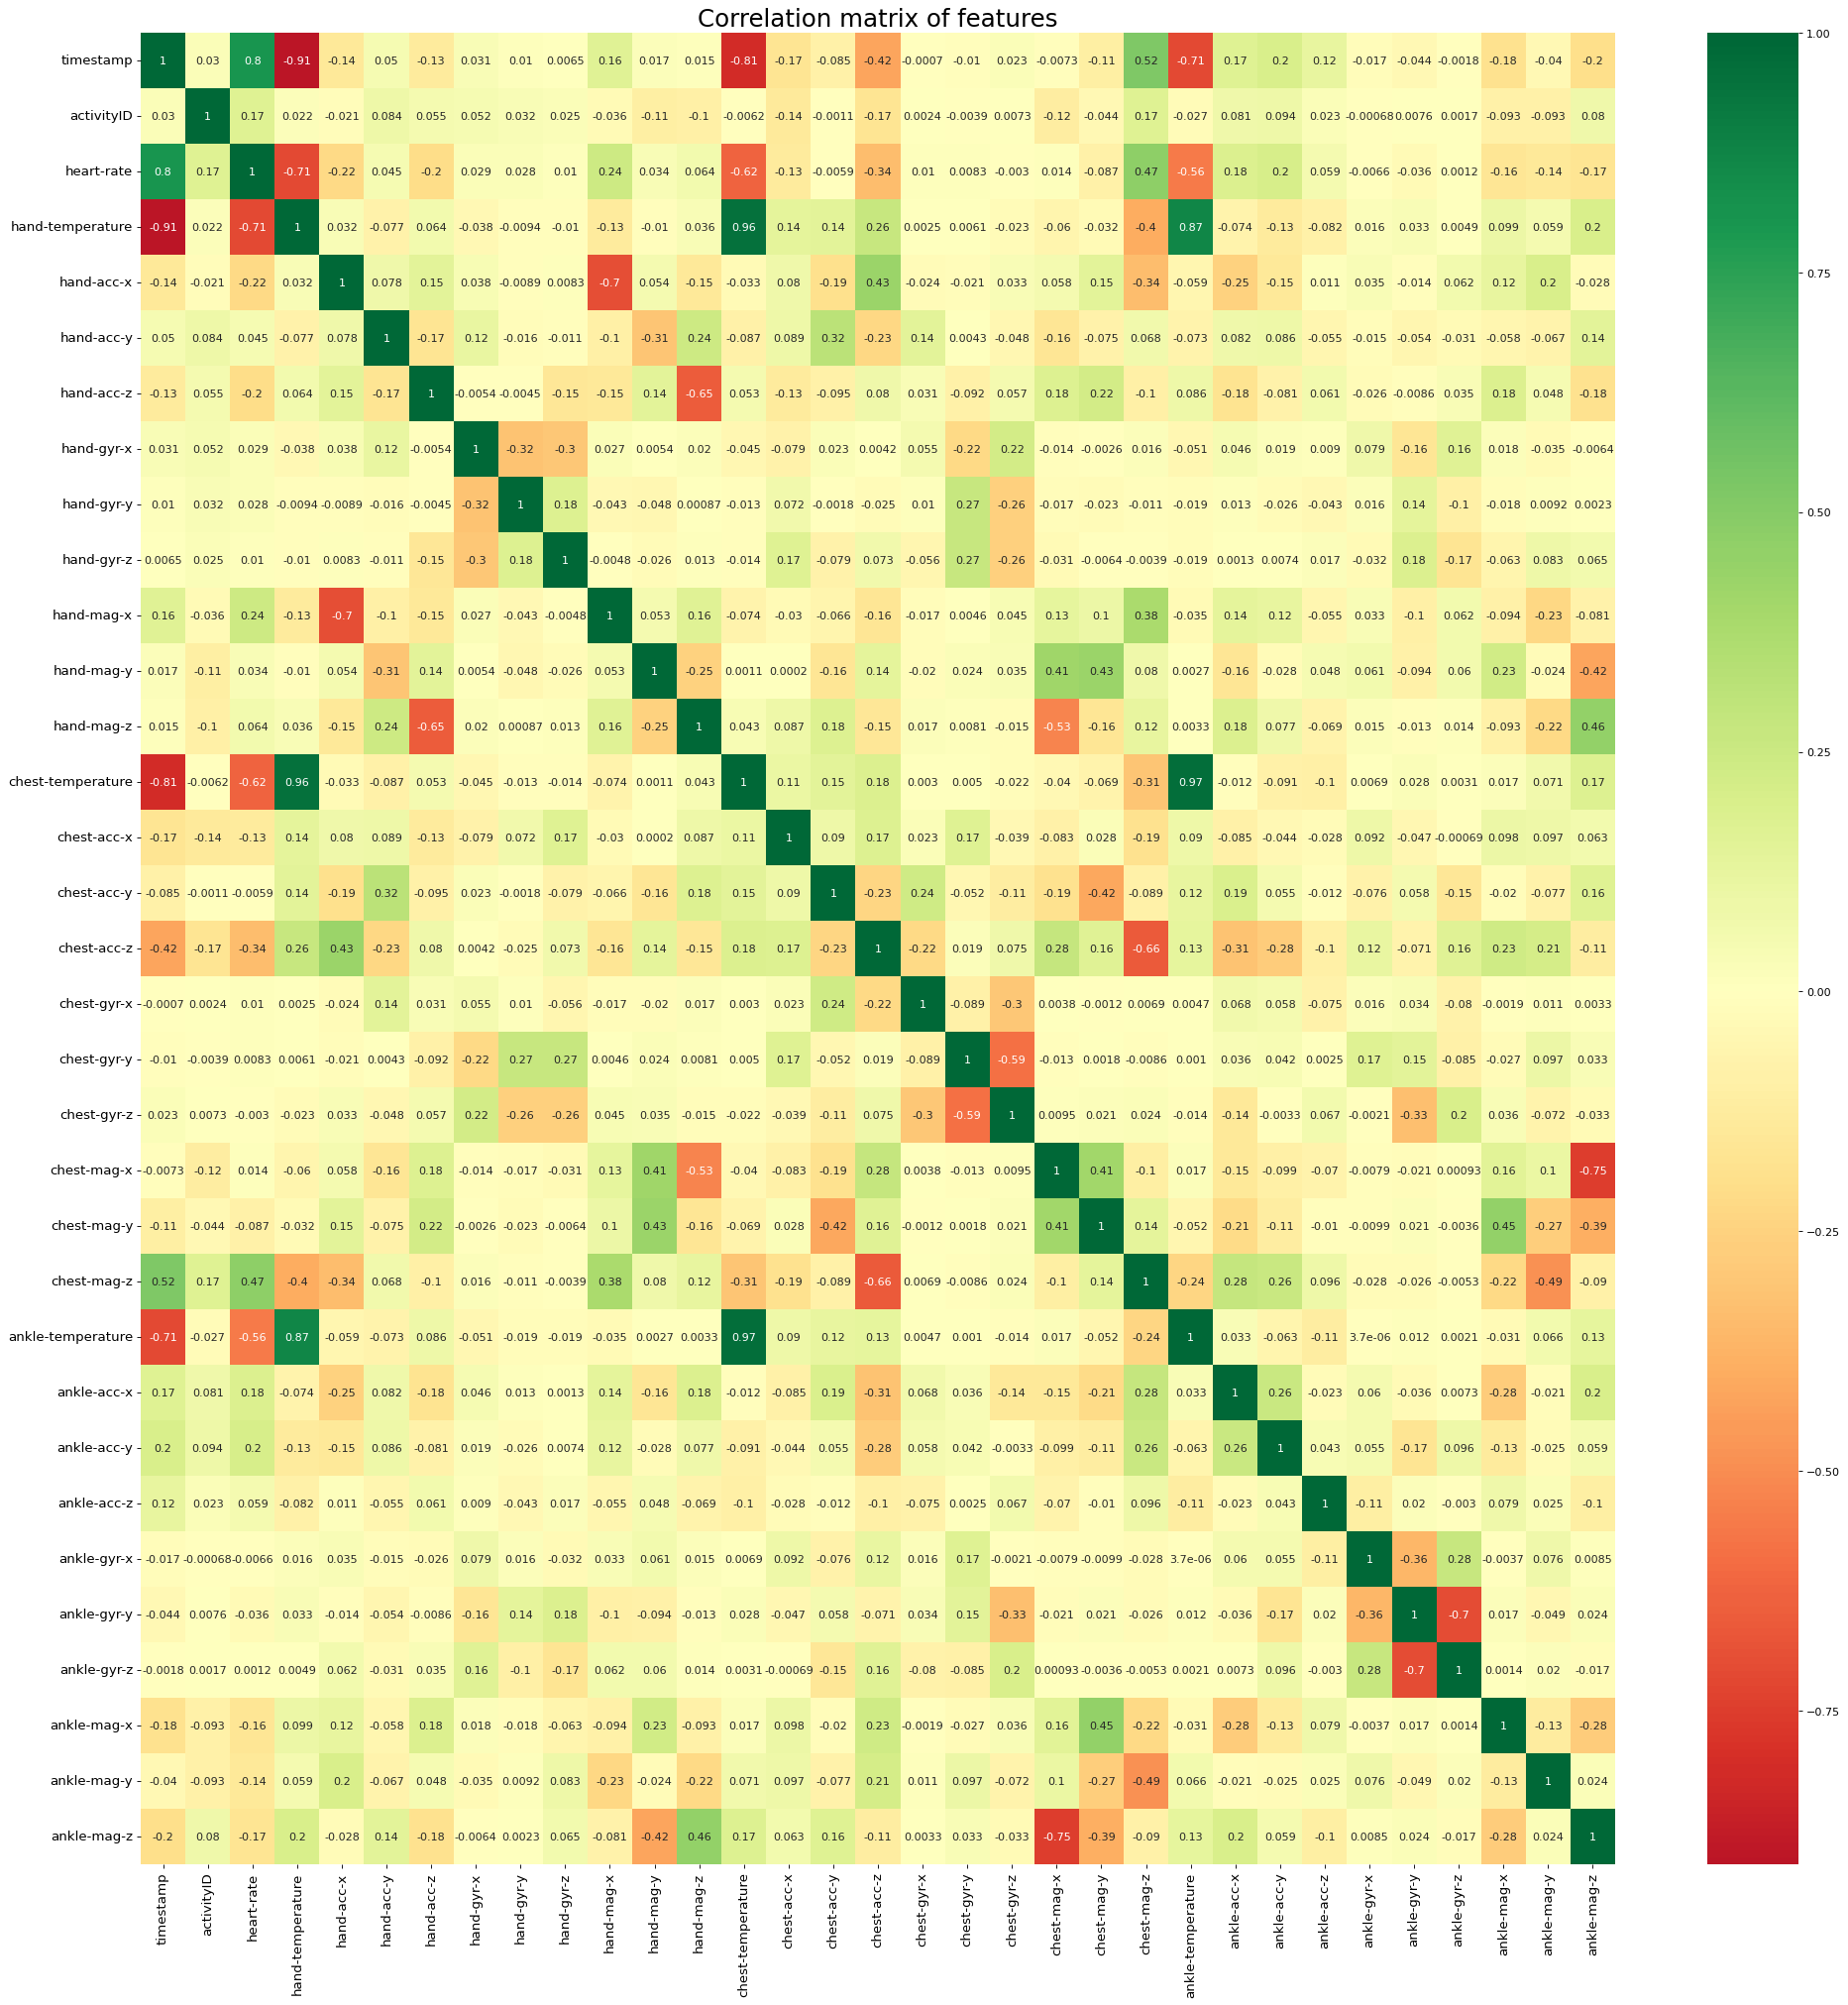

In [22]:
col = df_2.columns
# Plot
plt.figure(figsize=(30,30), dpi= 80)
sns.heatmap(df_2.corr(), xticklabels=col, yticklabels=col, cmap='RdYlGn', center=0, annot=True)
# Decorations
plt.title('Correlation matrix of features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

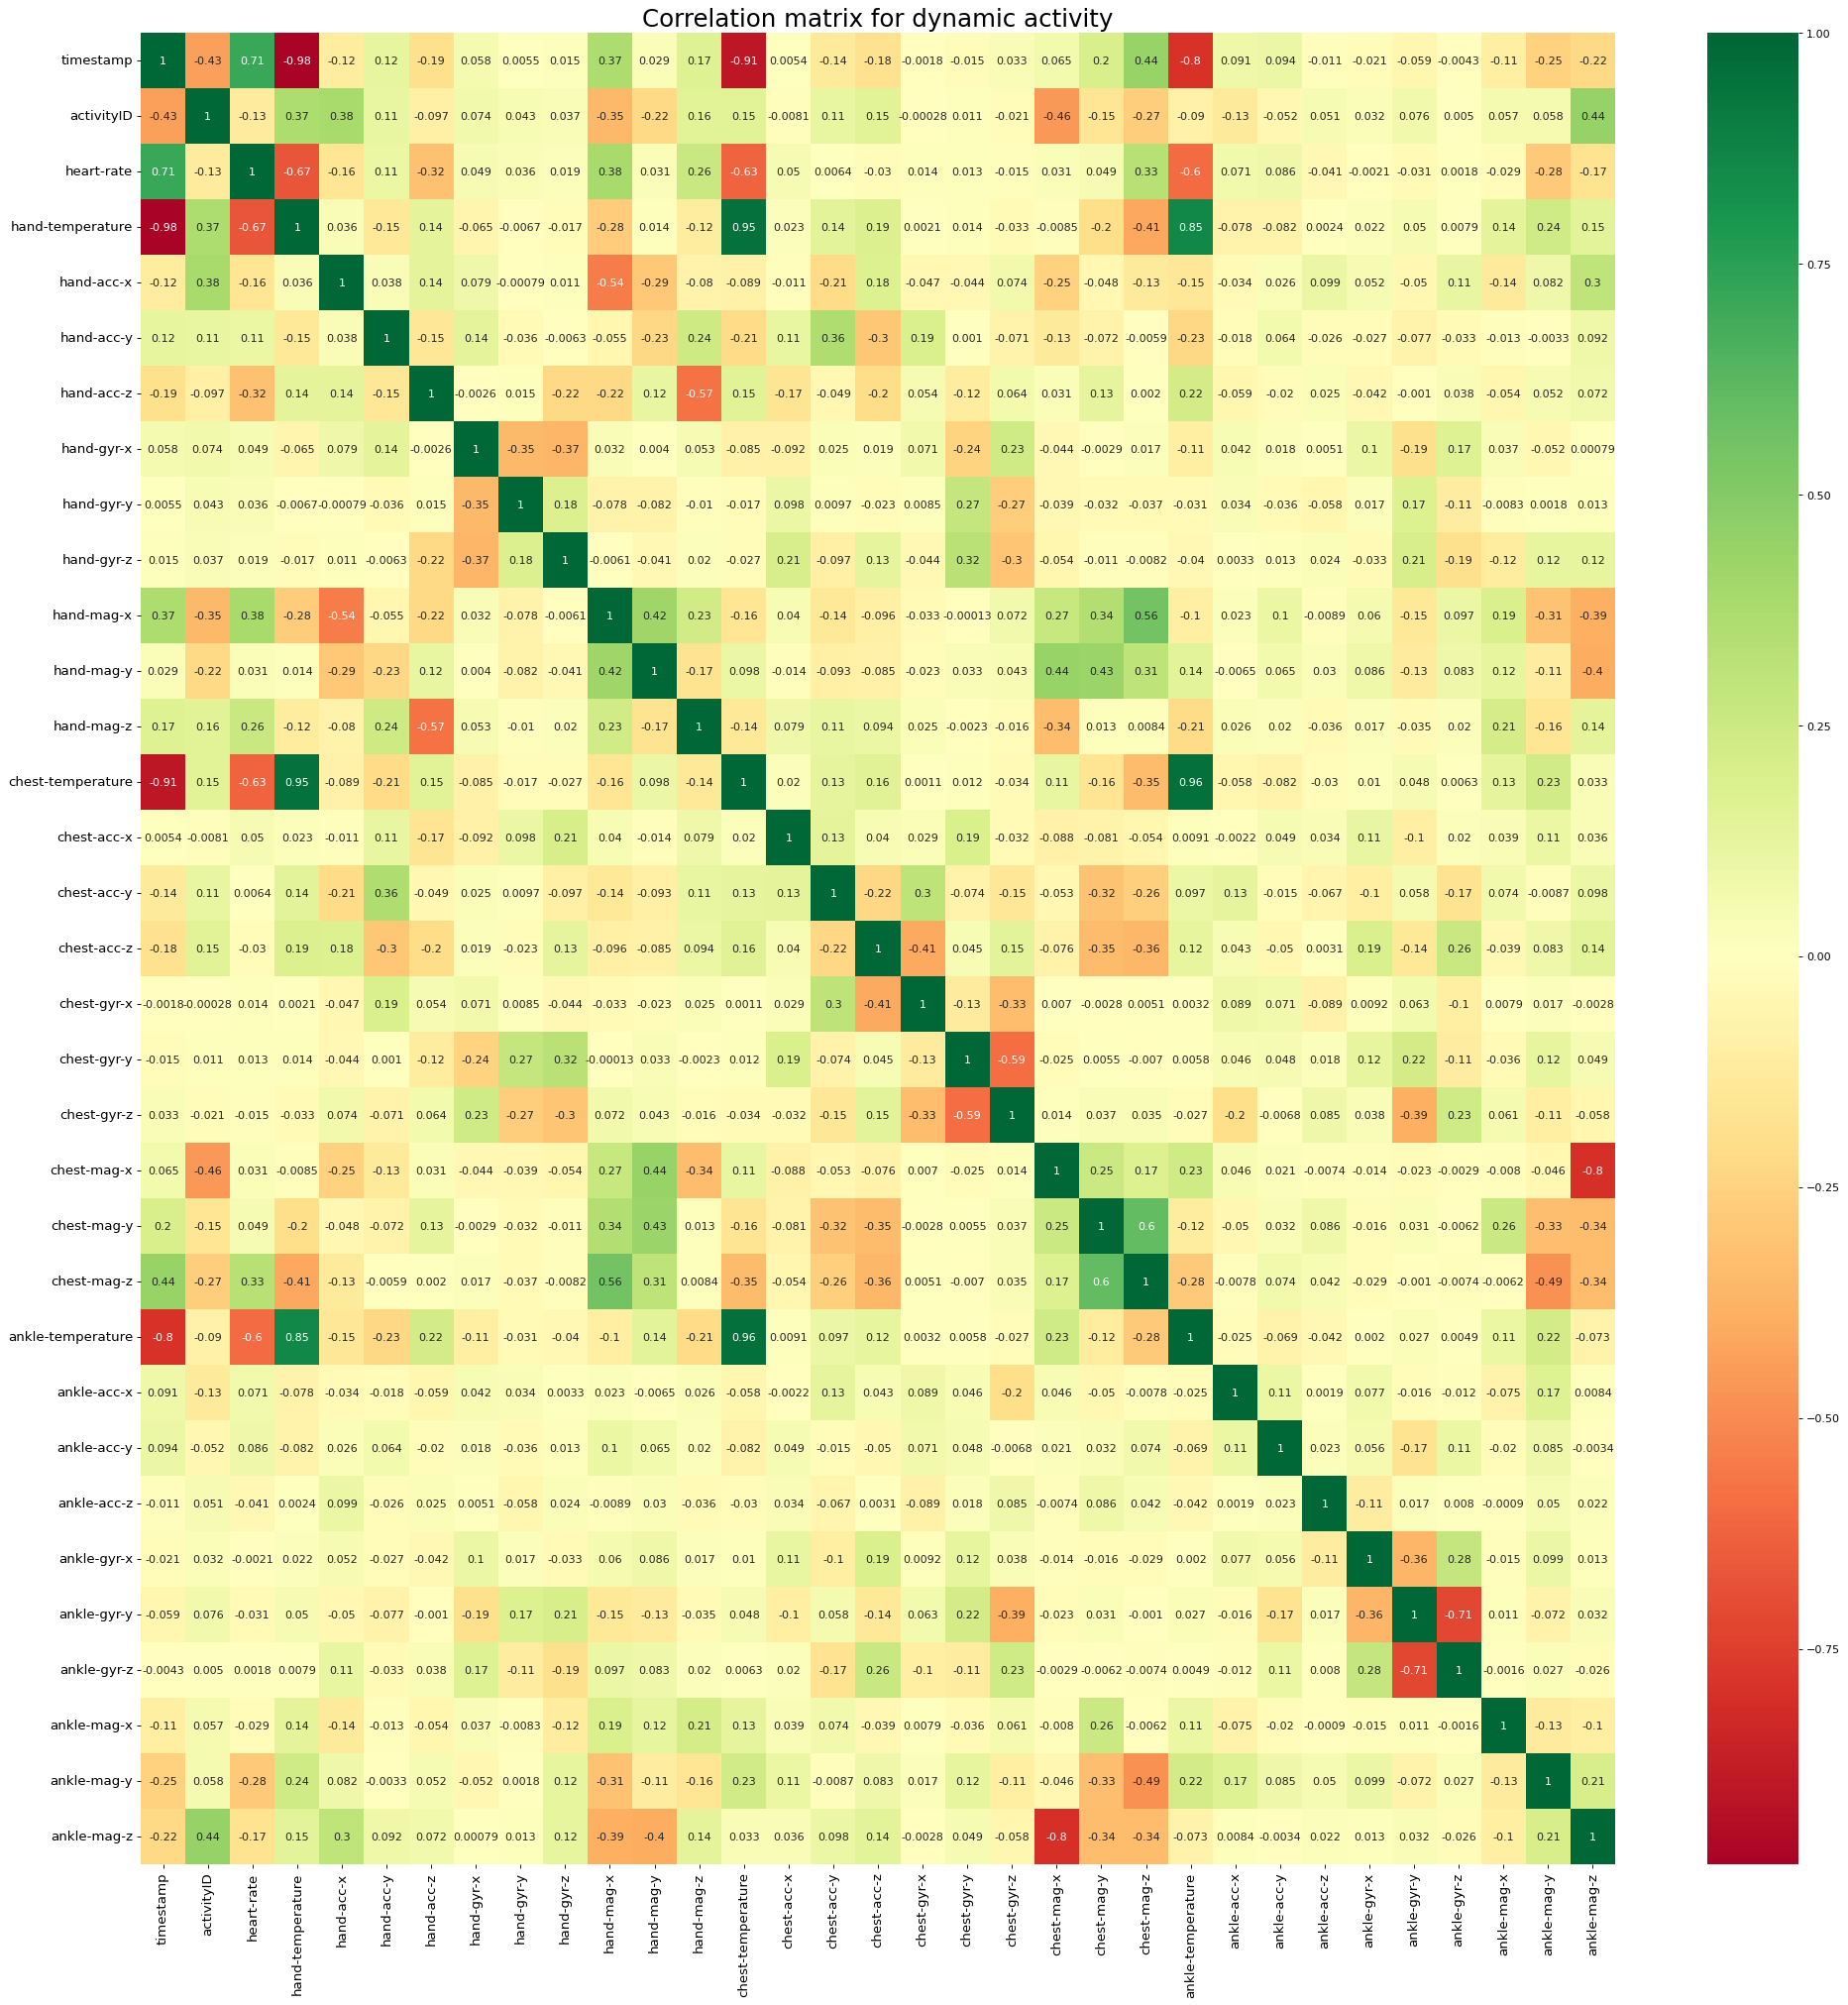

In [37]:
# Plot
plt.figure(figsize=(30,30), dpi= 80)
sns.heatmap(df_2[(df_2.activityID == 4 )| (df_2.activityID ==5)| (df_2.activityID ==6)|(df_2.activityID == 7)|(df_2.activityID > 11)].corr(), xticklabels=col, yticklabels=col, cmap='RdYlGn', center=0, annot=True)
# Decorations
plt.title(f'Correlation matrix for dynamic activity', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

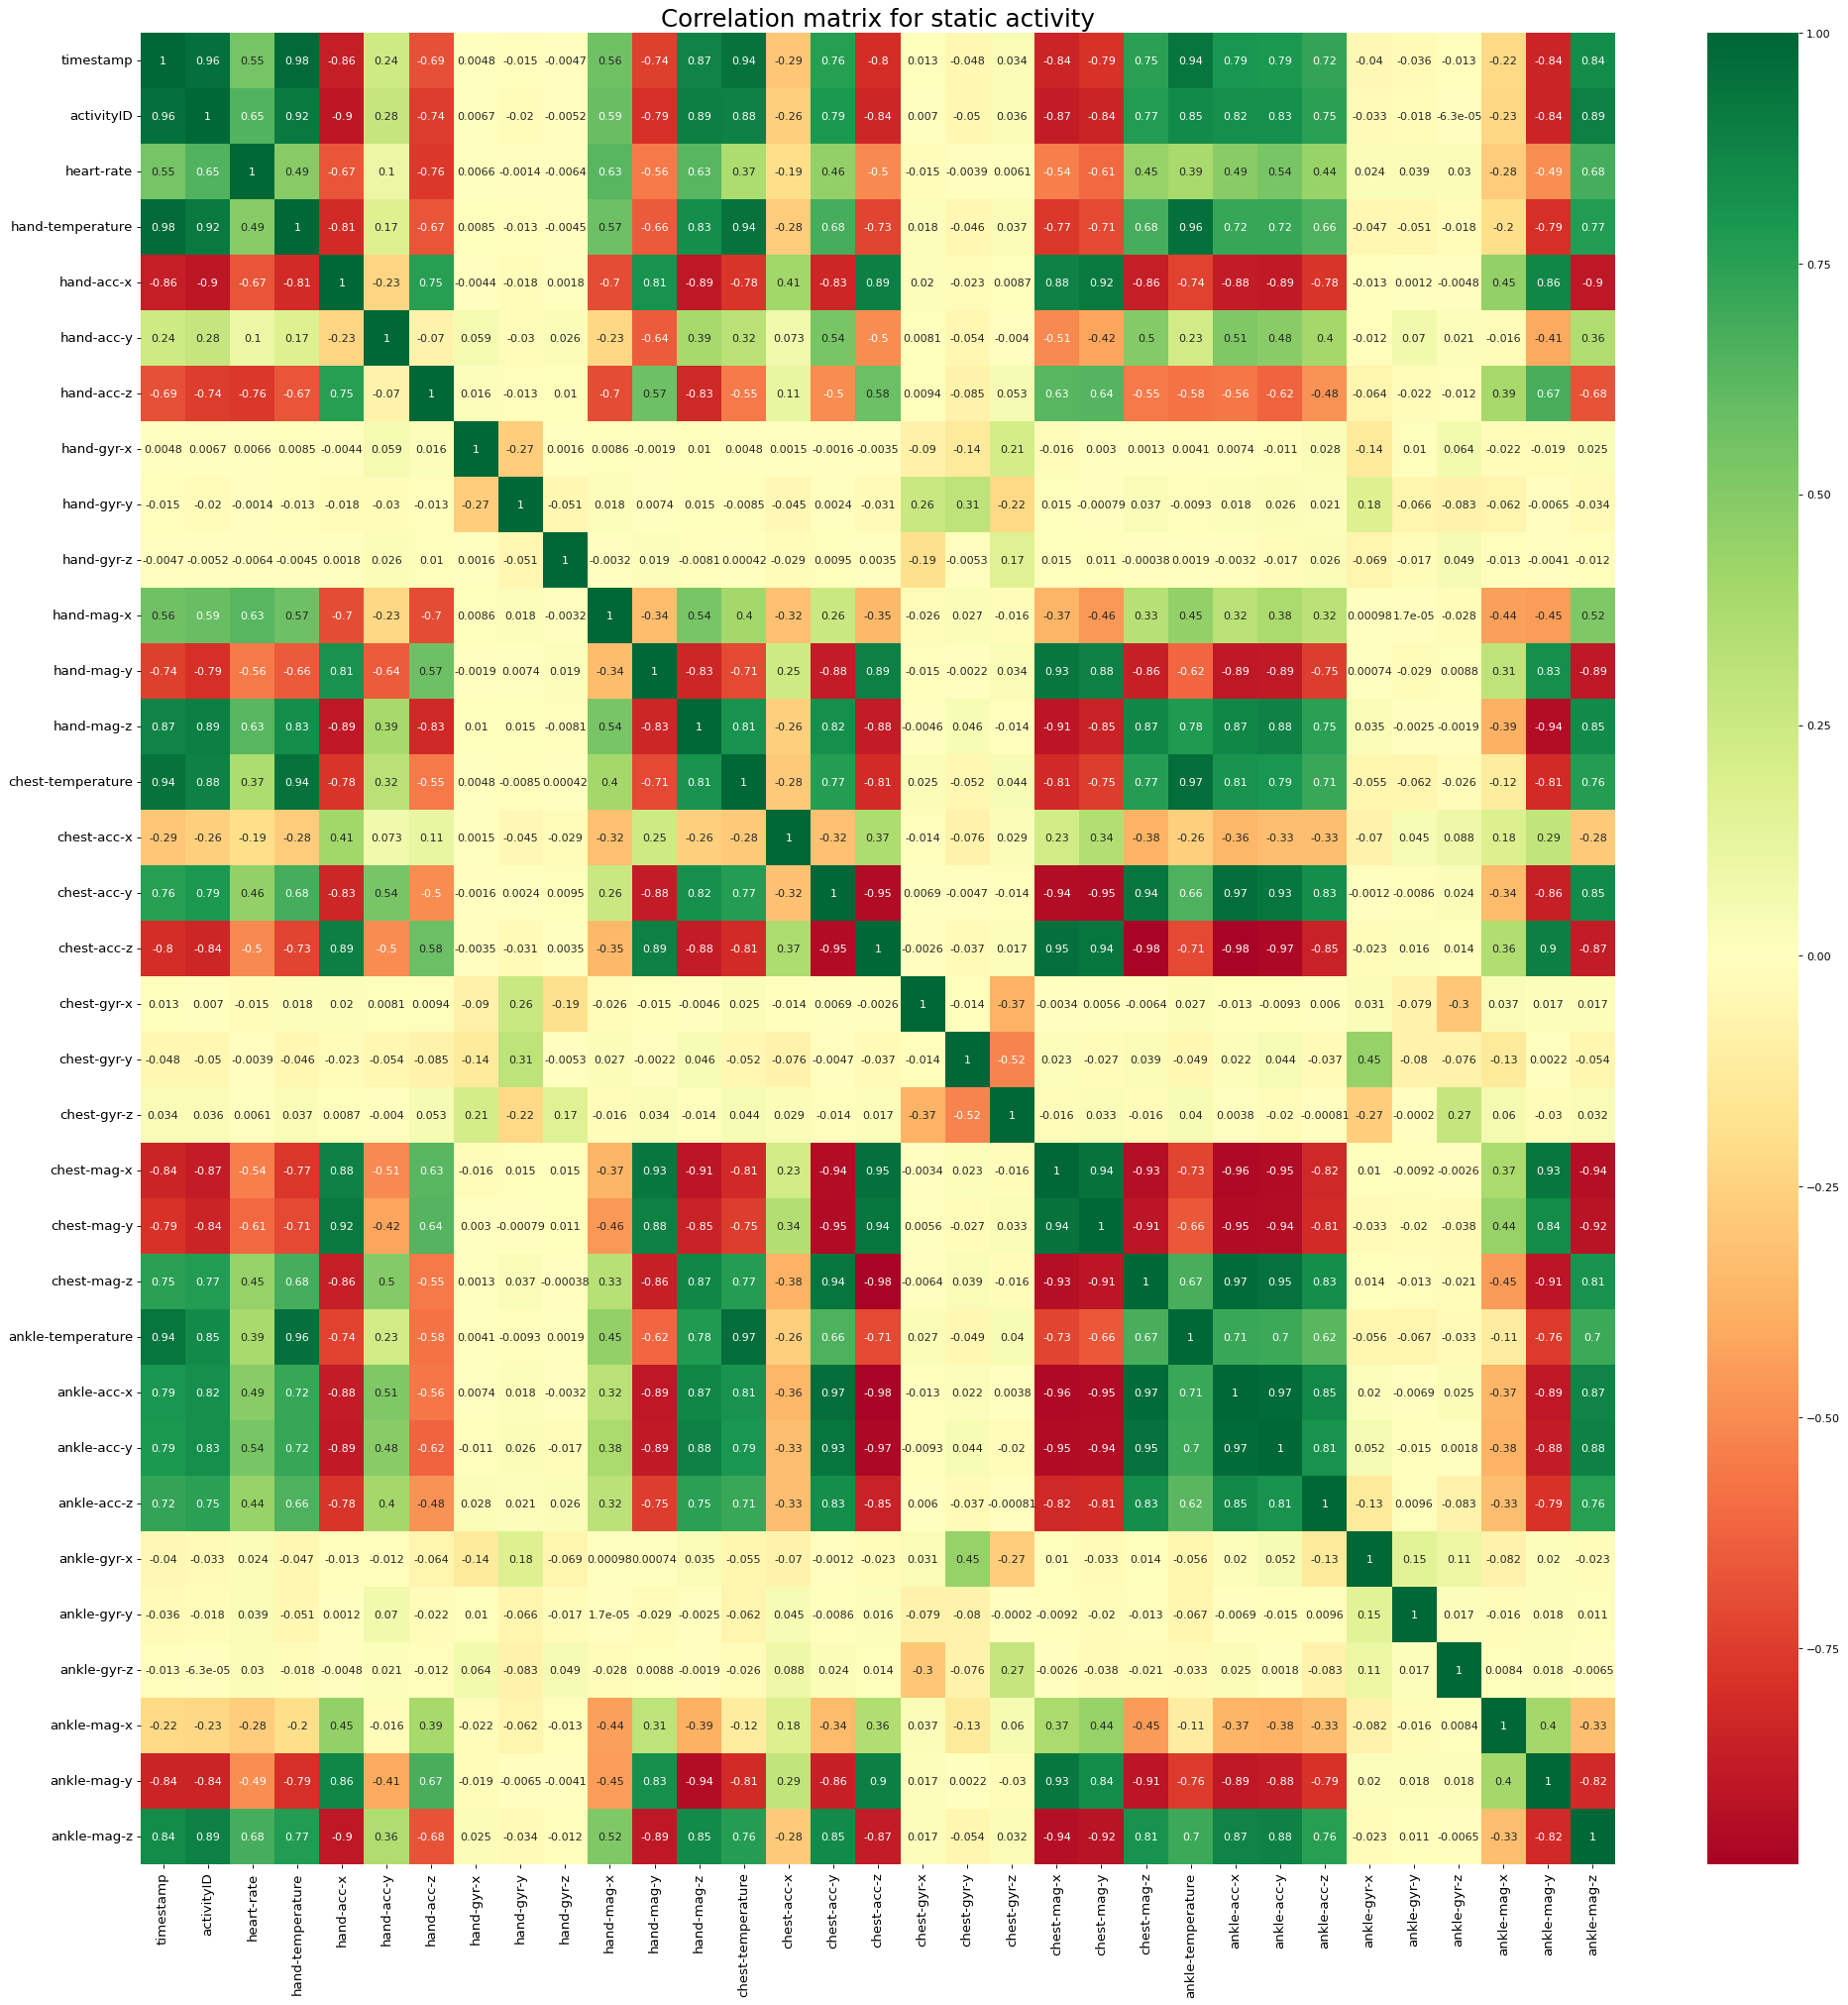

In [36]:
# Plot
plt.figure(figsize=(30,30), dpi= 80)
sns.heatmap(df_2[(df_2.activityID == 1 )| (df_2.activityID ==2)| (df_2.activityID ==3)|(df_2.activityID == 9)|(df_2.activityID == 10)|(df_2.activityID == 11)].corr(), xticklabels=col, yticklabels=col, cmap='RdYlGn', center=0, annot=True)
# Decorations
plt.title(f'Correlation matrix for static activity', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Mission 2
### section a - Decide Validation strategy

Our validation strategy works in the form of ***sliding windows***. The reason we used this strategy is because if we use the K-Fold group 
we predicted that an overfitting situation could arise in the training set. 
Our training set consists of subjects {101:106,109} and the test set consists of subjects {107,108} as we required.
In order to adapt the training set that will be a relevant bench mark in the future to the Lstm model we are interested in creating, we divided
the training set into a sequence with a window size of 400, with a stride size of 100 (non-overlapping between the windows).

### 2.b - Creating a Naïve baseline based on the heart rate data
**Calculate heart rate statistics for training data**

In [ ]:
all_means = {}
means = {}
stdev = {}
for i in np.unique(y_test):
    all_means[i], means[i], stdev[i] = [], [], np.float16()
for sequence in X_train:
    mean = sequence[1].mean() # mean of heart rate of sequence
    all_means[int(sequence[0][0])].append(mean)
for i in all_means: # calculate mean for each activity
    means[i] = sum(all_means[i])/len(all_means[i]) # calculate mean for activity
    stdev[i] = sqrt(sum([(x - means[i])**2 for x in all_means[i]]) / float(len(all_means[i]))) # calculate std.v for activity
    print(f'Heart Rate description for activity {i} -  mean is: {means[i]}, STD.V is: {stdev[i]} for {len(all_means[i])} sequences')

In [ ]:
# Calculate mean of heart rate for X_test
# return activity by MAE from mean heart rate of activity
def find_min_dist(mean):
    min = np.inf
    for x in all_means:
        temp = abs(mean-means[x])
        if temp < min:
            min = temp
            activity = x
    return activity

In [ ]:
pred_test = []
for sequence in X_test:
    mean = sequence[0].mean() # mean of heart rate of sequence
    activity_test = find_min_dist(mean) # min distance from all activities heart rate mean
    pred_test.append(activity_test)

In [ ]:
naive_report = metrics.classification_report(y_test,pred_test, output_dict=True)
ax = plt.axes()
sns.heatmap(pd.DataFrame(naive_report).iloc[:-1, :].T, annot=True, cmap = "Blues", ax = ax)
ax.set_title('Heat Map for Classification report')
print(metrics.classification_report(y_test,pred_test))
print(f'Naive baseline accuracy on test: {round(metrics.accuracy_score(y_test,pred_test)*100,3)} %')

In [ ]:
cm = metrics.confusion_matrix(y_test,pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize = (10,10))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion matrix by Activity")

### 2.c - Classical ML model - Random Forest

In [ ]:
# Function to create a new df with means from all attributes
def create_mean_df(df):
    temp_df = pd.DataFrame(index = range(len(df)), columns= range(31)) # create df by size of sequences in data
    for i,sequence in enumerate(df):
        mean = sequence.mean() # mean of sequence
        temp_df.loc[i] = mean # append mean of sequences to df
    return temp_df

In [ ]:
X_train, y_train = pre_training(train_data, subject_train)
X_test, y_test = pre_training(test_data, subject_test)
X_train = create_mean_df(X_train)
X_test = create_mean_df(X_test)

In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth=10, n_estimators=10, max_features="sqrt")

#Train the model using the training set
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
warnings.filterwarnings('ignore')
clf_report = metrics.classification_report(y_test,y_pred, output_dict=True)
print(metrics.classification_report(y_test,y_pred))
# Model Accuracy, how often is the classifier correct
print(f'Random Forest accuracy on test: {round(metrics.accuracy_score(y_test,y_pred)*100,3)} %')
ax = plt.axes()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap = "Greens", ax = ax)
ax.set_title('Heat Map for Classification report')

In [ ]:
cm = metrics.confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize = (10,10))
disp.plot(cmap="Greens", ax=ax)

plt.title("Confusion Matrix By Activity")

# section d - construct , fit and evaluate Neural Network 

In [122]:
def sliding_window(df, window_size, stride):
    data = df.copy()
    data = data.reset_index(drop=True)
    data = data.to_numpy()
    data_list = []
    for i in range(0, len(data), stride):
        if i + window_size < len(data):
            data_list.append(data[i:i+window_size])
        else:
            return torch.Tensor(data_list)

#Function to interpolate NaNs because we want to keep the data continuous
def interpolate_nans(df):
    df = df.interpolate(method='linear', axis=0).ffill().bfill()
    return df

In [123]:
train_data = {}

keys = loaded_file.keys()
keys = [key for key in keys if key not in [107,108]]
list_of_classes = list(number_to_activity.keys())

window_size = 400
num_features = 33
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = loaded_file[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        train_data[key,label] = sliding_window(new_data, window_size, stride)

Now reading subject number 101
Now reading subject number 102
Now reading subject number 103
Now reading subject number 104
Now reading subject number 105
Now reading subject number 106
Now reading subject number 109


In [126]:
test_data = {}


keys = [107,108]
list_of_classes = list(number_to_activity.keys())

window_size = 400
num_features = 33
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = loaded_file[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        test_data[key,label] = sliding_window(new_data, window_size, stride)

Now reading subject number 107
Now reading subject number 108


In [127]:
# saving the data for future work
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [76]:
def calc_trend(df,feature):
    if df[-1,feature] > df[0,feature]:
        return 1
    else:
        return 0

In [78]:
pretraining_df = train_data
#Pool the data together for each activity
subjects = [101,102,103,104,105,106,109]

X = {}
y = {}

activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","21"]
#Pool the data together for each activity
for activity in activities:
    X[activity] = torch.empty(0,400,33)
    for subject in subjects:
        if pretraining_df[(subject,activity)] is not None :
            X[activity] = torch.cat((X[activity],pretraining_df[(subject,activity)]),0)

feature_for_trend = 22
#Creating the labels for the data that will serve as the pretrain
#The way we are doing it is by calculating the trend of the data for some feature (in oour case the 22nd feature)
#Then we will use this trend as the label for the data
#Our model job will be to predict the trend of the data using the pretrain data
for activity in activities:
    y[activity] = []
    for sample in range(X[activity].shape[0]):
        trend = calc_trend(X[activity][sample],feature_for_trend)
        y[activity].append(calc_trend(X[activity][sample],22))

y_t= []
X_t = []
for act in activities:
    for sequence in X[act]:
        # print(sequence.shape)
        X_t.append(sequence[:,2:])   # drop time stamp and activity ID 
        y_t.append(int(act))

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X_t,y_t,test_size=0.2,shuffle=True)

In [86]:
len(X_train), len(y_train), len(X_val), len(y_val)

(16996, 16996, 4250, 4250)

In [97]:
# saving the data for future work
with open('y_train.pickle', 'wb') as f:
    pickle.dump(y_t, f)


In [ ]:
with open('X_train.pickle', 'wb') as f:
    pickle.dump(X_t, f)

In [ ]:
# saving the data for future work
with open('y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
pd.to_pickle(X_train, 'X_train.pickle')
pd.to_pickle(y_train, 'y_train.pickle')
pd.to_pickle(X_val, 'X_val.pickle')
pd.to_pickle(y_val, 'y_val.pickle')

In [81]:
class activity_dataset(Dataset):    
    def __init__(self, X, y, transform=None, trarget_transform=None):
        self.X = X 
        self.y = y
        self.transform = transform
        self.target_transform = trarget_transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return X, y

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Computation resource: {device}')

Computation resource: cuda


In [91]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=256, num_layers=2, output_dim=22, dropout=0):
        '''
        input_dim = number of features at each time step 
        hidden_dim = number of features produced by each LSTM cell (in each layer)
        num_layers = number of LSTM layers
        output_dim = number of classes (number of activities)
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, X):
        hidden_features, (h_n, c_n) = self.lstm(X)  # (h_0, c_0) default to zeros
        hidden_features = hidden_features[:,-1,:]  # index only the features produced by the last LSTM cell
        out = self.fc(hidden_features)
        return out

In [92]:
def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    train_acc = tp/size    
        
    return train_loss,train_acc

def validation_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    val_loss /= num_batches
    val_acc = tp/size
    print(f'accuracy = {val_acc}, val_loss = {val_loss:2f}')
    return val_loss,val_acc

In [93]:
batch_size=64
train_loader = DataLoader(activity_dataset(X_train,y_train), shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(activity_dataset(X_val,y_val), shuffle=False, batch_size=batch_size)
lr = 0.001
n_epochs = 10
# num_train_batches = len(train_data)
# iterations_per_epoch = len(train_loader)
best_acc = 0
# patience, patience_counter = 50, 0

model = LSTM_Classifier(dropout=0.75)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [ ]:
run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 100
patience = 5
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    torch.save(model.state_dict(), f'model_{epoch}.pth')
    val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

In [152]:
with open('results.pickle', 'rb') as handle:
    results_dict = pickle.load(handle)

In [154]:
df = pd.DataFrame(results_dict)

In [ ]:
df

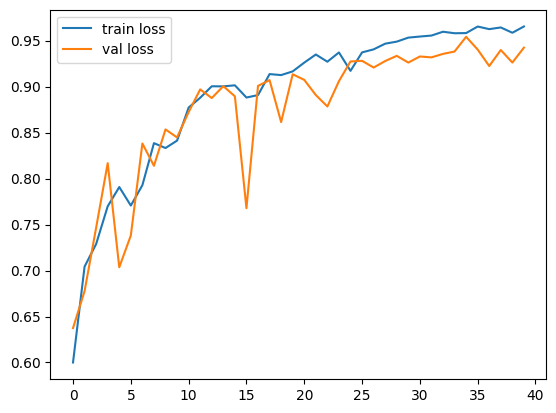

In [178]:
plt.plot(df.index ,df.train_acc, label = "train loss")
plt.plot(df.index , df.val_acc, label = "val loss")
plt.title = 'Learning curve'
# plt.xlabel('epoch')
# plt.ylabel('loss')
plt.legend()
plt.show()

# section e 

In [ ]:
pretraining_df = pd.read_pickle("C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")
#Pool the data together for each activity
activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","24"]

subjects = [101,102,103,104,105,106,109]
subjects_test = [107,108]

x_train = pool_data(pretraining_df,subjects,activities,400)
x_test = pool_data(pretraining_df,subjects_test,activities,400)
#Create labels for pretraining
feature_for_trend = 2 # 2 is the x axis
x_train_pooled,y_train_pooled= create_labels_for_pretraining(x_train,activities,feature_for_trend)
x_test_pooled,y_test_pooled = create_labels_for_pretraining(x_test,activities,feature_for_trend)
x_train_pooled = torch.stack(x_train_pooled)
x_test_pooled = torch.stack(x_test_pooled)
y_train_pooled = torch.Tensor(y_train_pooled)
y_test_pooled = torch.Tensor(y_test_pooled)
y_test_pooled.unique(return_counts=True)

#Fine tuning task
x_train_finetuning , y_train_finetuning = get_labels(x_train,activities)
x_test_finetuning , y_test_finetuning = get_labels(x_test,activities)
x_train_finetuning = torch.stack(x_train_finetuning)
x_test_finetuning = torch.stack(x_test_finetuning)
y_train_finetuning = torch.Tensor(y_train_finetuning)
y_test_finetuning = torch.Tensor(y_test_finetuning)
y_test_finetuning.unique(return_counts=True)

In [ ]:
class activity_dataset(Dataset):    
    def __init__(self, X, y, transform=None, trarget_transform=None):
        self.X = X 
        self.y = y
        self.transform = transform
        self.target_transform = trarget_transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return X, y

In [ ]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=256, num_layers=2, output_dim=22, dropout=0):
        '''
        input_dim = number of features at each time step 
        hidden_dim = number of features produced by each LSTM cell (in each layer)
        num_layers = number of LSTM layers
        output_dim = number of classes (number of activities)
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, X):
        hidden_features, (h_n, c_n) = self.lstm(X)  # (h_0, c_0) default to zeros
        hidden_features = hidden_features[:,-1,:]  # index only the features produced by the last LSTM cell
        out = self.fc(hidden_features)
        return out

# Pretraining the Network

x_train_pooled,x_val_pooled,y_train_pooled,y_val_pooled = train_test_split(x_train_pooled,y_train_pooled,test_size=0.2,shuffle=True)


In [ ]:
#Pretraining Configurations
batch_size=64
train_loader = DataLoader(activity_dataset(x_train_pooled,y_train_pooled), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(activity_dataset(x_val_pooled,y_val_pooled), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_pooled,y_test_pooled), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5,input_dim=30)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [ ]:
run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Pretraining-2ndTrial"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'pretraining_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Pretraining_{time.time()}.pickle")

## Finetuning the pretrained network


In [ ]:
weight_prob_dict = { 
        '0': 0.012
        ,'1': 0.059
        ,'2': 0.055
        ,'3': 0.06 
        ,'4': 0.048
        ,'5': 0.107
        ,'6': 0.072
        ,'7': 0.063
        ,'12': 0.097
        ,'13':0.102
        ,'16':0.064
        ,'17':0.047
        ,'21':0.215 }
x_train_finetuning,x_val_finetuning,y_train_finetuning,y_val_finetuning = train_test_split(x_train_finetuning,y_train_finetuning,test_size=0.2,shuffle=True)
x_train_finetuning.shape


In [ ]:
#Creating Weights to deal with imbalanced dataset
total = y_train_finetuning.unique(return_counts=True)[1].sum().item()
probas = [x.item()/total for x in  y_train_finetuning.unique(return_counts=True)[1]]
probas = np.round(probas,3)
weights = 1/probas
weights = np.round(weights/sum(weights),3)
final_weights = []
for sample in y_train_finetuning:
    final_weights.append(weight_prob_dict[str(int(sample.item()))])

from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(final_weights, len(final_weights))


In [ ]:
batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5)
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [ ]:
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))


In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [ ]:
print(x_train_finetuning.shape,x_val_finetuning.shape,y_train_finetuning.shape,y_val_finetuning.shape)

In [ ]:
run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned{time.time()}.pickle")


In [ ]:
df = pd.DataFrame(results)
plt.plot(df.index ,df.train_loss, label = "train loss")
plt.plot(df.index , df.val_loss, label = "val loss")
plt.title = 'Learning curve'
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(df.index ,df.train_acc, label = "train accuracy")
plt.plot(df.index , df.val_acc, label = "val accuracy")
plt.title = 'Learning curve'
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
def sampling_test(data_loader,model,device):
    model.eval()
    preds = []
    gt = []
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            preds.append(pred.argmax(1).detach().cpu().numpy())
            gt.append(y.detach().cpu().numpy())
            
    return preds,gt

In [ ]:
sample_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)


In [ ]:
preds,gt = sampling_test(sample_loader,model,device)

In [ ]:
y_train_finetuning.unique(return_counts=True)[0]

In [ ]:
final_weights = np.array(final_weights)

In [ ]:

preds = np.concatenate(preds)
gt = np.concatenate(gt)

In [ ]:

from sklearn.metrics import accuracy_score,confusion_matrix
display(accuracy_score(gt,preds))
display(confusion_matrix(gt,preds))

## Using our pre-training task we realized we er're getting even worse results than without pretraining
## Therefore we figured the original feature we created as target has too much of a difference from our original task target distribution.
## We then tried to learn with the trend of the heartrate within a 4-sec time window as our target.
## That didn't work out too well as well.
## 3 Ideas to improve our results:
## 1) We can create a more complicated task for pretraining which resembles the original task a bit better.
## 2) We can try to get rid of class - 0 because it is all the transient activities which may look like another class in terms of the data but is labeled
## as 0 and therefor creates alot of noise for our algorithm
## 3) We can try a different model for our task.

In [ ]:
full_df= pd.read_pickle('subjects_data_new.pickle')

subject_data = {}

keys = full_df.keys()
# keys = [key for key in keys if key not in [107,108]]
list_of_classes = list(number_to_activity.keys())

window_size = 800
num_features = 33
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = full_df[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        subject_data[key,label] = sliding_window(new_data, window_size, stride)

pd.to_pickle(subject_data,"C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")

In [ ]:
pretraining_df = pd.read_pickle("C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")

In [ ]:
#Pool the data together for each activity
activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","24"]

subjects = [101,102,103,104,105,106,109]
subjects_test = [107,108]

x_train = pool_data(pretraining_df,subjects,activities,800)
x_test = pool_data(pretraining_df,subjects_test,activities,800)

#Fine tuning task
x_train_finetuning , y_train_finetuning = get_labels(x_train,activities)
x_test_finetuning , y_test_finetuning = get_labels(x_test,activities)
x_train_finetuning = torch.stack(x_train_finetuning)
x_test_finetuning = torch.stack(x_test_finetuning)
y_train_finetuning = torch.Tensor(y_train_finetuning)
y_test_finetuning = torch.Tensor(y_test_finetuning)
y_test_finetuning.unique(return_counts=True)



In [ ]:
weight_prob_dict = { 
        '0': 0.012
        ,'1': 0.059
        ,'2': 0.055
        ,'3': 0.06 
        ,'4': 0.048
        ,'5': 0.107
        ,'6': 0.072
        ,'7': 0.063
        ,'12': 0.097
        ,'13':0.102
        ,'16':0.064
        ,'17':0.047
        ,'21':0.215 }

x_train_finetuning,x_val_finetuning,y_train_finetuning,y_val_finetuning = train_test_split(x_train_finetuning,y_train_finetuning,test_size=0.2,shuffle=True)
#Creating Weights to deal with imbalanced dataset
total = y_train_finetuning.unique(return_counts=True)[1].sum().item()
probas = [x.item()/total for x in  y_train_finetuning.unique(return_counts=True)[1]]
probas = np.round(probas,3)
weights = 1/probas
weights = np.round(weights/sum(weights),3)
final_weights = []
for sample in y_train_finetuning:
    final_weights.append(weight_prob_dict[str(int(sample.item()))])


from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(final_weights, len(final_weights))


batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5)
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned_2{time.time()}.pickle")



In [ ]:
sample_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
preds,gt = sampling_test(sample_loader,model,device)
preds = np.concatenate(preds)
gt = np.concatenate(gt)
from sklearn.metrics import accuracy_score,confusion_matrix
display(accuracy_score(gt,preds))
display(confusion_matrix(gt,preds))

In [ ]:

batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5,hidden_dim=512)
#model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):s
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted__hidden_dim{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned_2{time.time()}.pickle")

